
# Data Load

Dataset: [Wikipedia Sentences](https://www.kaggle.com/datasets/mikeortman/wikipedia-sentences) (Kaggle)


Corpus Size: Middle 3000 sentences extracted

Model: TinyLlama

Total Layers: 23

Layers Analyzed: Layer 15 (2/3rd), Layer 22 (Last)


Each results in a 2 048-dim vector, producing two matrices of shape (2 000 × 2 048).

# Outline

**Clustering Analysis**
- cosine similarity grouping
- DBSCAN
- K-means
- HDBSCAN

In [ ]:
import nltk
import json

nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

corpus_path = "/content/wikisent.txt"
with open(corpus_path, 'r', encoding='utf-8') as file:
    corpus_text = file.read()

sentences = sent_tokenize(corpus_text)
print(f"Total number of sentences: {len(sentences)}")

num_sentences_to_extract = 3000

if len(sentences) > num_sentences_to_extract:
    mid_index = len(sentences) // 2
    half_window = num_sentences_to_extract // 2
    # extract the middle 2000 sentences
    sentences = sentences[mid_index - half_window : mid_index + half_window]

with open("book_sentences.json", "w", encoding="utf-8") as f:
    json.dump(sentences, f)

print(f"Saved extracted middle {len(sentences)} sentences as 'book_sentences.json'.")
print(f"Final number of sentences: {len(sentences)}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Total number of sentences: 7963525
Saved extracted middle 3000 sentences as 'book_sentences.json'.
Final number of sentences: 3000


In [ ]:
print(sentences)

['Malacoscylus lacordairei is a species of beetle in the family Cerambycidae.', 'Malacoscylus lanei is a species of beetle in the family Cerambycidae.', 'Malacoscylus niger is a species of beetle in the family Cerambycidae.', 'Malacoscylus xanthotaenius is a species of beetle in the family Cerambycidae.', 'Malacosoma californicum, the western tent caterpillar, is a moth of the family Lasiocampidae.', 'Malacosoma is a genus of moths in the family Lasiocampidae.', 'Malacosoma neustria caterpillars are brown with blue, orange and white stripes.', 'Malacosoma species are notable for their caterpillars which are brightly colored and form silken tents to regulate their temperature.', 'Malacosoma tigris, the sonoran tent caterpillar, is a species of insect in the family of moths known as Lasiocampidae.', 'Malacostegina is a sub-order of marine, colonial bryozoans in the order Cheilostomata.', 'Malacosteus and the related genera Aristostomias and Pachystomias are the only fishes that produce r

# Embedding model – TinyLlama
- tokenize each sentence, run the model, and return all hidden-state tensors.
- Extract last token vector from layer 15, 22

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords

In [ ]:
print("Loading LLaMA model...")
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # A smaller LLaMA-like model that's easy to run
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)

Loading LLaMA model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [ ]:
# tokenize text, run it through the model
def get_llama_token_embeddings(text, model, tokenizer, device):
    inputs = tokenizer(text, return_tensors="pt", max_length=256, truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    all_hidden_states = outputs.hidden_states
    last_hidden_state = all_hidden_states[-1]
    return tokens, all_hidden_states, last_hidden_state

In [ ]:
# extract the last token vector from a specific layer.
def get_last_token_vector(all_hidden_states, layer_idx):
    layer_output = all_hidden_states[layer_idx]
    last_token_vec = layer_output[:, -1, :].squeeze(0)
    return last_token_vec

In [ ]:
_, hidden_states, _ = get_llama_token_embeddings(sentences[0], model, tokenizer, device)
n_all = len(hidden_states)
print(f"Total hidden_states = {n_all}")

# 15th and last
selected_layers = [15, n_all-1]
print(f"Selected layers: {selected_layers}")

selected_layer_embeddings = {layer_idx: [] for layer_idx in selected_layers}

# extract last token embeddings for selected layers for each sentence
for text in tqdm(sentences):
    tokens, all_hidden_states, _ = get_llama_token_embeddings(text, model, tokenizer, device)
    for layer_idx in selected_layers:
        vec = get_last_token_vector(all_hidden_states, layer_idx)
        selected_layer_embeddings[layer_idx].append(vec)

for layer_idx in selected_layers:
    gpu_tensors = selected_layer_embeddings[layer_idx]
    selected_layer_embeddings[layer_idx] = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in gpu_tensors])
    hidden_dim = selected_layer_embeddings[layer_idx].shape[1]
    print(f"Layer {layer_idx}: {selected_layer_embeddings[layer_idx].shape} (num_sentences: {selected_layer_embeddings[layer_idx].shape[0]}, hidden_dim: {hidden_dim})")
print(f"Selected layers processed: {len(selected_layers)}")

Total hidden_states = 23
Selected layers: [15, 22]


100%|██████████| 3000/3000 [01:23<00:00, 35.78it/s]


Layer 15: (3000, 2048) (num_sentences: 3000, hidden_dim: 2048)
Layer 22: (3000, 2048) (num_sentences: 3000, hidden_dim: 2048)
Selected layers processed: 2


# Norm + Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import numpy as np

# cosine similarity for each selected layer
sim_matrix_layers = []
avg_similarity_layers = []


#Compute cosine similarity for each layer's sentence embeddings
for layer_idx in selected_layers:
    embeddings = selected_layer_embeddings[layer_idx]

    sim_matrix = cosine_similarity(embeddings)
    sim_matrix_layers.append(sim_matrix)

    # calculate average similarity
    triu_indices = np.triu_indices_from(sim_matrix, k=1)
    avg_similarity = sim_matrix[triu_indices].mean()
    avg_similarity_layers.append(avg_similarity)

    print(f"\nLayer {layer_idx}:")
    print(f"  Similarity Matrix Shape: {sim_matrix.shape}")
    print(f"  Average Pairwise Cosine Similarity = {avg_similarity:.3f}")



Layer 15:
  Similarity Matrix Shape: (3000, 3000)
  Average Pairwise Cosine Similarity = 0.539

Layer 22:
  Similarity Matrix Shape: (3000, 3000)
  Average Pairwise Cosine Similarity = 0.684


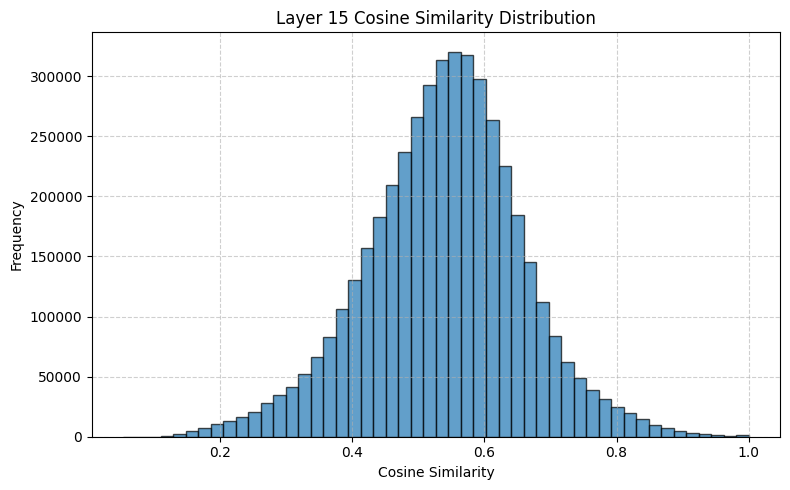


Layer 15 Cosine Similarity Statistics:
Mean: 0.5394
Median: 0.5442
Standard Deviation: 0.1188
Min: 0.0538
Max: 1.0000


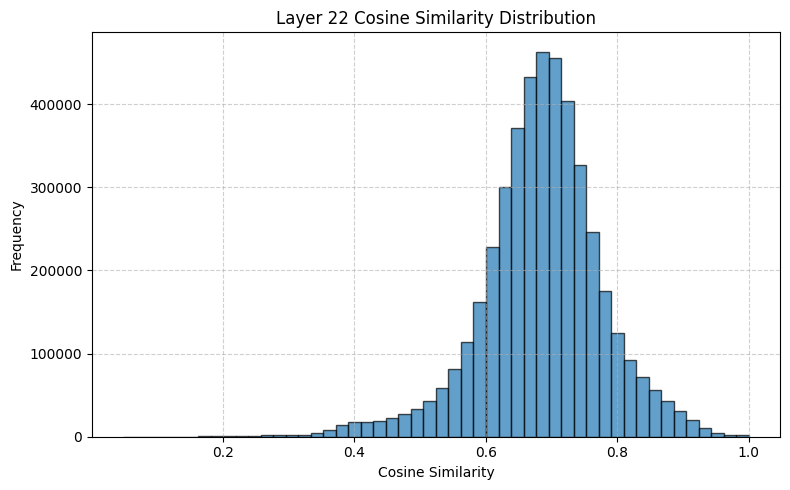


Layer 22 Cosine Similarity Statistics:
Mean: 0.6839
Median: 0.6879
Standard Deviation: 0.0932
Min: 0.0482
Max: 1.0000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# plot frequency distributions for each layer's normalized similarity matrix

for i, layer_idx in enumerate(selected_layers):
    sim_matrix = sim_matrix_layers[i]

    triu_indices = np.triu_indices_from(sim_matrix, k=1)
    sim_values = sim_matrix[triu_indices]

    plt.figure(figsize=(8, 5))
    plt.hist(sim_values, bins=50, edgecolor='black', alpha=0.7)
    plt.title(f"Layer {layer_idx} Cosine Similarity Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    print(f"\nLayer {layer_idx} Cosine Similarity Statistics:")
    print(f"Mean: {np.mean(sim_values):.4f}")
    print(f"Median: {np.median(sim_values):.4f}")
    print(f"Standard Deviation: {np.std(sim_values):.4f}")
    print(f"Min: {np.min(sim_values):.4f}")
    print(f"Max: {np.max(sim_values):.4f}")

# DBSCAN

In [ ]:
pip install kneed

In [ ]:
from sklearn.cluster import DBSCAN

def clustering_grouping(embedding, thres):
  eps = 1 - thres
  clustering = DBSCAN(eps=eps, min_samples=2, metric="cosine").fit(embedding)
  labels = clustering.labels_

  groups = {}
  for idx, label in enumerate(labels):
    if label not in groups:
      groups[label] = []
    groups[label].append(idx)
  return list(groups.values())

### DBSCAN Analysis: Slope, R-squared values for different eps values

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

def linear_regression(counts):
    valid_counts = counts[counts > 0]
    if len(valid_counts) <= 1:
        return None, None, 0, 0, 0, 1, None
    x = np.log10(np.arange(1, len(valid_counts)+1))
    y = np.log10(valid_counts)
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    y_pred = slope * x + intercept
    return x, y, slope, intercept, r_val, p_val, y_pred

In [ ]:
# count sentences in each cluster and sort
def count_sentences_per_cluster_dbscan(clusters):
    counts = [len(cluster) for cluster in clusters]
    return np.array(sorted(counts, reverse=True))

In [ ]:
dbscan_similarity_thresholds = np.linspace(0.85, 0.99, num=15)

dbscan_threshold_analysis_results = []

# Analyze each threshold for both layers
for current_similarity_threshold in dbscan_similarity_thresholds:
    # Layer 15 analysis
    layer_15_clusters_at_current_threshold = clustering_grouping(
        selected_layer_embeddings[selected_layers[0]],
        current_similarity_threshold
    )
    layer_15_cluster_sizes_at_current_threshold = count_sentences_per_cluster_dbscan(
        layer_15_clusters_at_current_threshold
    )

    # Get the top 5 cluster sizes for layer 15 (or fewer if there are less than 5 clusters)
    layer_15_top_cluster_sizes = layer_15_cluster_sizes_at_current_threshold[:min(5, len(layer_15_cluster_sizes_at_current_threshold))]
    layer_15_top_cluster_sizes_formatted = ', '.join(map(str, layer_15_top_cluster_sizes))

    # Calculate power law regression metrics for layer 15
    _, _, layer_15_power_law_slope, _, layer_15_r_squared, _, _ = linear_regression(
        layer_15_cluster_sizes_at_current_threshold
    )

    # Layer 22 analysis
    layer_22_clusters_at_current_threshold = clustering_grouping(
        selected_layer_embeddings[selected_layers[1]],
        current_similarity_threshold
    )
    layer_22_cluster_sizes_at_current_threshold = count_sentences_per_cluster_dbscan(
        layer_22_clusters_at_current_threshold
    )

    # Get the top 5 cluster sizes for layer 22 (or fewer if there are less than 5 clusters)
    layer_22_top_cluster_sizes = layer_22_cluster_sizes_at_current_threshold[:min(5, len(layer_22_cluster_sizes_at_current_threshold))]
    layer_22_top_cluster_sizes_formatted = ', '.join(map(str, layer_22_top_cluster_sizes))

    # Calculate power law regression metrics for layer 22
    _, _, layer_22_power_law_slope, _, layer_22_r_squared, _, _ = linear_regression(
        layer_22_cluster_sizes_at_current_threshold
    )

    # Store the analysis results for this threshold
    dbscan_threshold_analysis_results.append({
        'Similarity_Threshold': current_similarity_threshold,
        'Layer_15_Cluster_Count': len(layer_15_clusters_at_current_threshold),
        'Layer_15_Top_Cluster_Sizes': layer_15_top_cluster_sizes_formatted,
        'Layer_15_R_Squared': layer_15_r_squared**2,
        'Layer_15_Power_Law_Slope': layer_15_power_law_slope,
        'Layer_22_Cluster_Count': len(layer_22_clusters_at_current_threshold),
        'Layer_22_Top_Cluster_Sizes': layer_22_top_cluster_sizes_formatted,
        'Layer_22_R_Squared': layer_22_r_squared**2,
        'Layer_22_Power_Law_Slope': layer_22_power_law_slope
    })

# Convert results to DataFrame for easier manipulation and display
dbscan_analysis_results_df = pd.DataFrame(dbscan_threshold_analysis_results)


In [ ]:
print(dbscan_analysis_results_df)

    Similarity_Threshold  Layer_15_Cluster_Count Layer_15_Top_Cluster_Sizes  \
0                   0.85                     101   1125, 796, 393, 149, 144   
1                   0.86                     101   1245, 420, 363, 316, 147   
2                   0.87                     105   1356, 389, 329, 273, 142   
3                   0.88                     110   1473, 352, 294, 219, 136   
4                   0.89                     111   1593, 310, 251, 204, 135   
5                   0.90                     138   1712, 233, 198, 135, 119   
6                   0.91                     142    1873, 170, 169, 128, 68   
7                   0.92                     158     2003, 161, 125, 68, 54   
8                   0.93                     151     2149, 139, 122, 53, 41   
9                   0.94                     138      2268, 117, 92, 50, 25   
10                  0.95                     124       2391, 91, 64, 49, 23   
11                  0.96                     116    

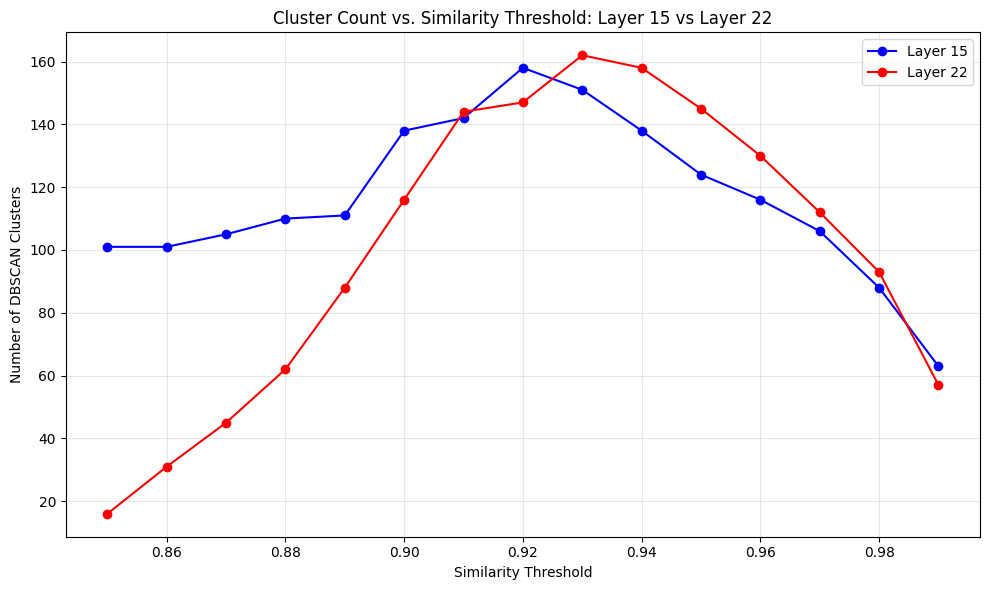

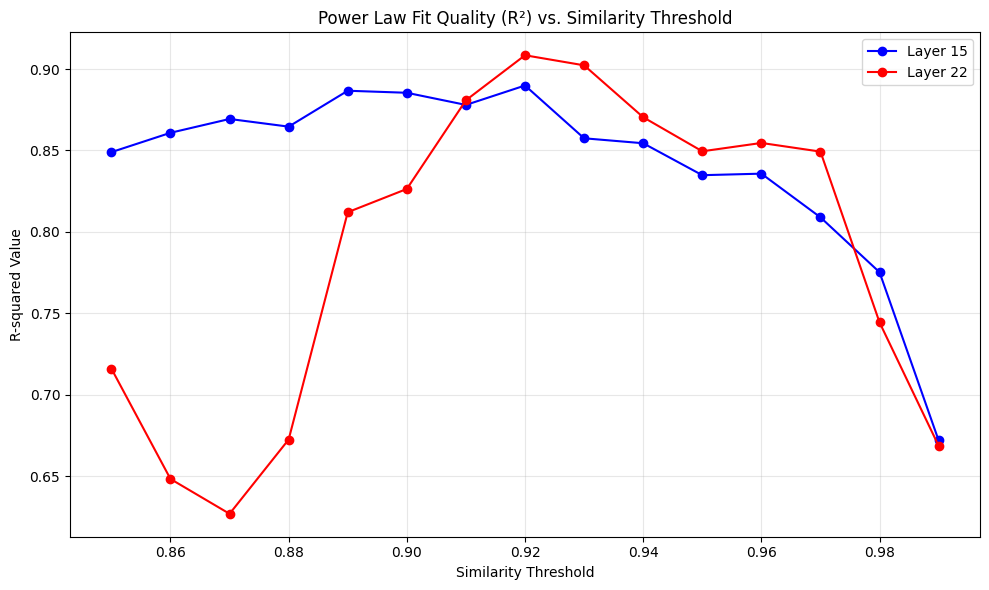

In [ ]:
# Create visualization of the crossing pattern between layers
import matplotlib.pyplot as plt

# Plot showing how cluster counts change with similarity threshold
layer_comparison_cluster_count_fig = plt.figure(figsize=(10, 6))
plt.plot(
    dbscan_analysis_results_df['Similarity_Threshold'],
    dbscan_analysis_results_df['Layer_15_Cluster_Count'],
    'b-o',
    label='Layer 15'
)
plt.plot(
    dbscan_analysis_results_df['Similarity_Threshold'],
    dbscan_analysis_results_df['Layer_22_Cluster_Count'],
    'r-o',
    label='Layer 22'
)
plt.xlabel('Similarity Threshold')
plt.ylabel('Number of DBSCAN Clusters')
plt.title('Cluster Count vs. Similarity Threshold: Layer 15 vs Layer 22')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('dbscan_cluster_threshold_comparison.png')
plt.show()

# Plot showing how R² values change with similarity threshold
r_squared_comparison_fig = plt.figure(figsize=(10, 6))
plt.plot(
    dbscan_analysis_results_df['Similarity_Threshold'],
    dbscan_analysis_results_df['Layer_15_R_Squared'],
    'b-o',
    label='Layer 15'
)
plt.plot(
    dbscan_analysis_results_df['Similarity_Threshold'],
    dbscan_analysis_results_df['Layer_22_R_Squared'],
    'r-o',
    label='Layer 22'
)
plt.xlabel('Similarity Threshold')
plt.ylabel('R-squared Value')
plt.title('Power Law Fit Quality (R²) vs. Similarity Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('dbscan_rsquared_threshold_comparison.png')
plt.show()

#### Best threshold

In [ ]:
# Find the similarity threshold that produces the highest R² value for each layer
layer_15_best_rsquared_index = dbscan_analysis_results_df['Layer_15_R_Squared'].idxmax()
layer_15_best_rsquared_row = dbscan_analysis_results_df.iloc[layer_15_best_rsquared_index]

layer_22_best_rsquared_index = dbscan_analysis_results_df['Layer_22_R_Squared'].idxmax()
layer_22_best_rsquared_row = dbscan_analysis_results_df.iloc[layer_22_best_rsquared_index]


print("\layer 15 (upper middle layer) OPTIMAL THRESHOLD:")
print(f"Similarity Threshold: {layer_15_best_rsquared_row['Similarity_Threshold']:.2f}")
print(f"R² Value: {layer_15_best_rsquared_row['Layer_15_R_Squared']:.4f}")
print(f"Power Law Slope: {layer_15_best_rsquared_row['Layer_15_Power_Law_Slope']:.4f}")
print(f"Number of Clusters: {layer_15_best_rsquared_row['Layer_15_Cluster_Count']}")
print(f"Top Cluster Sizes: {layer_15_best_rsquared_row['Layer_15_Top_Cluster_Sizes']}")

print("\layer 22 OPTIMAL THRESHOLD:")
print(f"Similarity Threshold: {layer_22_best_rsquared_row['Similarity_Threshold']:.2f}")
print(f"R² Value: {layer_22_best_rsquared_row['Layer_22_R_Squared']:.4f}")
print(f"Power Law Slope: {layer_22_best_rsquared_row['Layer_22_Power_Law_Slope']:.4f}")
print(f"Number of Clusters: {layer_22_best_rsquared_row['Layer_22_Cluster_Count']}")
print(f"Top Cluster Sizes: {layer_22_best_rsquared_row['Layer_22_Top_Cluster_Sizes']}")


\layer 15 (upper middle layer) OPTIMAL THRESHOLD:
Similarity Threshold: 0.92
R² Value: 0.8899
Power Law Slope: -0.9454
Number of Clusters: 158
Top Cluster Sizes: 2003, 161, 125, 68, 54
\layer 22 OPTIMAL THRESHOLD:
Similarity Threshold: 0.92
R² Value: 0.9085
Power Law Slope: -1.1261
Number of Clusters: 147
Top Cluster Sizes: 1142, 449, 345, 223, 212


### Run DBSCAN Final Chosen eps

In [ ]:
# middle layer (layer 15)
dbscan_middle_layer = clustering_grouping(selected_layer_embeddings[selected_layers[0]], 0.92)

# last layer (layer 22)
dbscan_last_layer = clustering_grouping(selected_layer_embeddings[selected_layers[1]], 0.92)


print(f"\nMiddle layer (Layer {selected_layers[0]}):")
print(f"Number of clusters: {len(dbscan_middle_layer)}")

print(f"\nLast layer (Layer {selected_layers[1]}):")
print(f"Number of clusters: {len(dbscan_last_layer)}")


Middle layer (Layer 15):
Number of clusters: 158

Last layer (Layer 22):
Number of clusters: 147


In [ ]:
import numpy as np


# count sentences per cluster for each layer
vector_sent_dbscan_middle = count_sentences_per_cluster_dbscan(dbscan_middle_layer)
vector_sent_dbscan_last = count_sentences_per_cluster_dbscan(dbscan_last_layer)

print("\nUpper Middle layer sentence counts (sorted):")
print(vector_sent_dbscan_middle)

print("\nLast layer sentence counts (sorted):")
print(vector_sent_dbscan_last)



Upper Middle layer sentence counts (sorted):
[2003  161  125   68   54   31   25   25   16   15   13   13   12   12
   11   10    9    9    8    7    7    7    6    6    6    5    5    5
    4    4    4    4    4    4    4    4    4    4    4    4    4    4
    4    4    4    3    3    3    3    3    3    3    3    3    3    3
    3    3    3    3    3    3    3    3    3    3    3    3    3    3
    3    3    3    3    3    3    3    2    2    2    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2]

Last layer sentence counts (sorted):
[1142  449  345  223  212   39   31   26   20   19   17   14   13   12
   11   11   11   10   10    9    9    9  

### **KMEANS**

In [ ]:
pip install kneed

In [ ]:
# Normalize embeddings
norm_layer_15 = normalize(selected_layer_embeddings[selected_layers[0]], norm='l2')
norm_layer_22 = normalize(selected_layer_embeddings[selected_layers[1]], norm='l2')

In [ ]:
from kneed import KneeLocator

def find_optimal_k(embeddings, k_samples=None, k_min=5, k_max=50, k_step=None, random_sampling=False, plot=True):
    # random sampling or sequential?
    if random_sampling:
        random.seed(42)
        K = sorted(random.sample(range(k_min, k_max + 1), k_samples))
    else:
        K = list(range(k_min, k_max + 1, k_step if k_step else 1))

    # calculate WCSS for each k value
    wcss = []
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    # find the knee point using KneeLocator
    knee = KneeLocator(K, wcss, curve='convex', direction='decreasing')
    optimal_k = knee.knee

    # plot the results if plot=True
    if plot and optimal_k:
        plt.figure(figsize=(8, 5))
        plt.plot(K, wcss, 'bo-', label='WCSS')
        plt.axvline(optimal_k, color='red', linestyle='--', label=f'Knee at k={optimal_k}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('WCSS (Inertia)')
        plt.title('Elbow Method for Optimal k')
        plt.legend()
        plt.grid(True)
        plt.show()

    return optimal_k


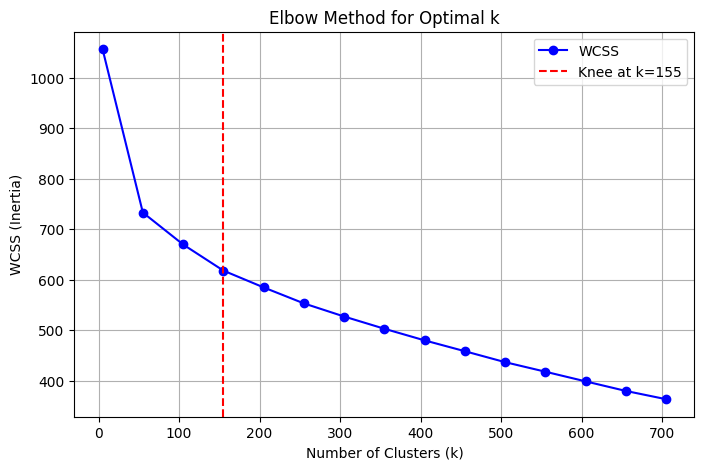

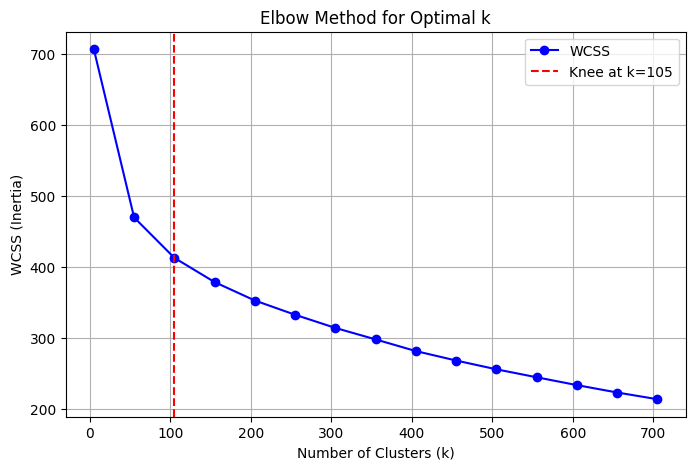

In [ ]:
optimal_k_15 = find_optimal_k(norm_layer_15, k_min=5, k_max=705, k_step=50)
optimal_k_22 = find_optimal_k(norm_layer_22, k_min=5, k_max=705, k_step=50)

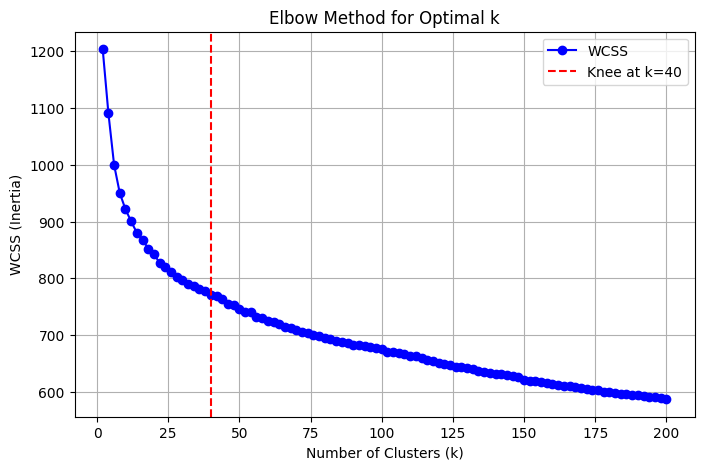

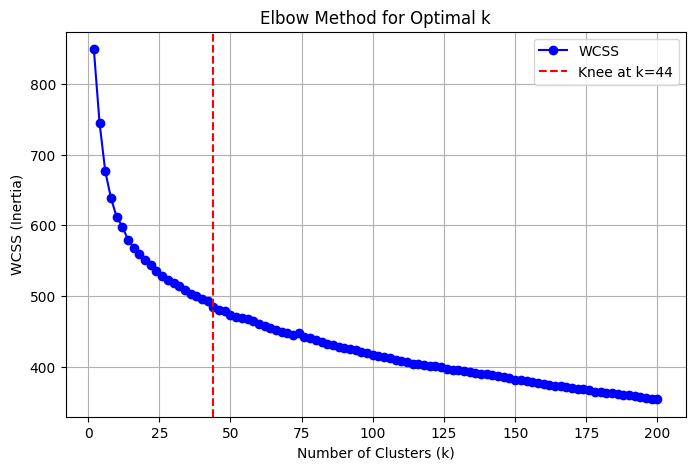

In [ ]:
optimal_k_15 = find_optimal_k(norm_layer_15, k_min=2, k_max=200, k_step=2)
optimal_k_22 = find_optimal_k(norm_layer_22, k_min=2, k_max=200, k_step=2)

In [ ]:
kmeans_middle_layer = KMeans(n_clusters=40, random_state=42)
kmeans_last_layer = KMeans(n_clusters=44, random_state=42)

# Fit K-means to the raw embeddings
middle_layer_labels = kmeans_middle_layer.fit_predict(norm_layer_15)
last_layer_labels = kmeans_last_layer.fit_predict(norm_layer_22)


In [ ]:
def count_sentences_per_cluster(cluster_labels):
    unique, counts = np.unique(cluster_labels, return_counts=True)
    return counts

sentences_per_cluster_middle = count_sentences_per_cluster(middle_layer_labels)
sentences_per_cluster_last = count_sentences_per_cluster(last_layer_labels)

# sentence count stored in vector
import numpy as np

vector_sent_kmeans_mid = np.array(sorted(sentences_per_cluster_middle, reverse=True))
vector_sent_kmeans_last = np.array(sorted(sentences_per_cluster_last, reverse=True))


print("\nmiddle layer sentence counts (sorted):")
print(vector_sent_kmeans_mid)

print("\nlast layer sentence counts (sorted):")
print(vector_sent_kmeans_last)


middle layer sentence counts (sorted):
[140 136 134 127 122 115 112 101  97  97  95  92  89  89  87  86  85  82
  78  76  73  70  67  66  66  60  58  57  55  55  47  47  43  42  35  29
  28  25  23  14]

last layer sentence counts (sorted):
[182 152 136 134 129 107 101  97  94  93  85  84  82  82  81  79  78  77
  75  67  65  62  58  56  55  53  49  46  45  44  44  43  42  41  39  37
  36  31  29  29  29  27  23   2]


# **Cosine Similarity Grouping**

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def grouping(cos_similar, n, thres):
  groups = []
  visited = set()

  for i in range(n):
    if i in visited:
      continue

    group = [i]
    visited.add(i)

    for j in range(i+1, n):
      if cos_similar[i][j] >= thres:
        group.append(j)
        visited.add(j)

    groups.append(group)

  return groups

### Examine Cosine similarity thresholds vs. R-squared and slope

In [ ]:
# function to extract sorted counts of sentences per cluster
def count_sentences_per_cluster_grouping(groups):
    counts = [len(group) for group in groups]
    return np.array(sorted(counts, reverse=True))

In [ ]:
cosine_similarity_thresholds = np.linspace(0.6, 0.99, num=40)

# create a results table for tracking metrics across thresholds
cosine_grouping_threshold_analysis_results = []

layer_15_embeddings = selected_layer_embeddings[selected_layers[0]]
layer_22_embeddings = selected_layer_embeddings[selected_layers[1]]

layer_15_cosine_similarity_matrix = cosine_similarity(layer_15_embeddings)
layer_22_cosine_similarity_matrix = cosine_similarity(layer_22_embeddings)

n_samples_layer_15 = layer_15_embeddings.shape[0]
n_samples_layer_22 = layer_22_embeddings.shape[0]

# analyze each threshold for both layers
for current_similarity_threshold in cosine_similarity_thresholds:
    # layer 15 analysis
    layer_15_groups_at_current_threshold = grouping(
        layer_15_cosine_similarity_matrix,
        n_samples_layer_15,
        current_similarity_threshold
    )
    layer_15_group_sizes_at_current_threshold = count_sentences_per_cluster_grouping(
        layer_15_groups_at_current_threshold
    )

    # top 5 group sizes
    layer_15_top_group_sizes = layer_15_group_sizes_at_current_threshold[:min(5, len(layer_15_group_sizes_at_current_threshold))]
    layer_15_top_group_sizes_formatted = ', '.join(map(str, layer_15_top_group_sizes))

    # power law regression metrics
    _, _, layer_15_power_law_slope, _, layer_15_r_squared, _, _ = linear_regression(
        layer_15_group_sizes_at_current_threshold
    )

    # layer 22 analysis
    layer_22_groups_at_current_threshold = grouping(
        layer_22_cosine_similarity_matrix,
        n_samples_layer_22,
        current_similarity_threshold
    )
    layer_22_group_sizes_at_current_threshold = count_sentences_per_cluster_grouping(
        layer_22_groups_at_current_threshold
    )

    # top 5 group sizes
    layer_22_top_group_sizes = layer_22_group_sizes_at_current_threshold[:min(5, len(layer_22_group_sizes_at_current_threshold))]
    layer_22_top_group_sizes_formatted = ', '.join(map(str, layer_22_top_group_sizes))

    # power law regression metrics
    _, _, layer_22_power_law_slope, _, layer_22_r_squared, _, _ = linear_regression(
        layer_22_group_sizes_at_current_threshold
    )

    # store analysis results
    cosine_grouping_threshold_analysis_results.append({
        'Similarity_Threshold': current_similarity_threshold,
        'Layer_15_Group_Count': len(layer_15_groups_at_current_threshold),
        'Layer_15_Top_Group_Sizes': layer_15_top_group_sizes_formatted,
        'Layer_15_R_Squared': layer_15_r_squared**2,
        'Layer_15_Power_Law_Slope': layer_15_power_law_slope,
        'Layer_22_Group_Count': len(layer_22_groups_at_current_threshold),
        'Layer_22_Top_Group_Sizes': layer_22_top_group_sizes_formatted,
        'Layer_22_R_Squared': layer_22_r_squared**2,
        'Layer_22_Power_Law_Slope': layer_22_power_law_slope
    })

# results to dataframe
cosine_grouping_results_df = pd.DataFrame(cosine_grouping_threshold_analysis_results)

In [ ]:
print(cosine_grouping_results_df)

    Similarity_Threshold  Layer_15_Group_Count  Layer_15_Top_Group_Sizes  \
0                   0.60                    85  1331, 925, 771, 750, 657   
1                   0.61                   100  1223, 821, 799, 647, 627   
2                   0.62                   111  1076, 717, 668, 532, 527   
3                   0.63                   128   964, 856, 772, 620, 533   
4                   0.64                   139   882, 777, 675, 549, 504   
5                   0.65                   169   925, 776, 708, 565, 408   
6                   0.66                   192   809, 692, 646, 365, 340   
7                   0.67                   220   683, 639, 578, 315, 298   
8                   0.68                   257   579, 565, 513, 409, 321   
9                   0.69                   282   744, 534, 447, 372, 276   
10                  0.70                   331   659, 495, 331, 314, 264   
11                  0.71                   369   578, 456, 377, 255, 251   
12          

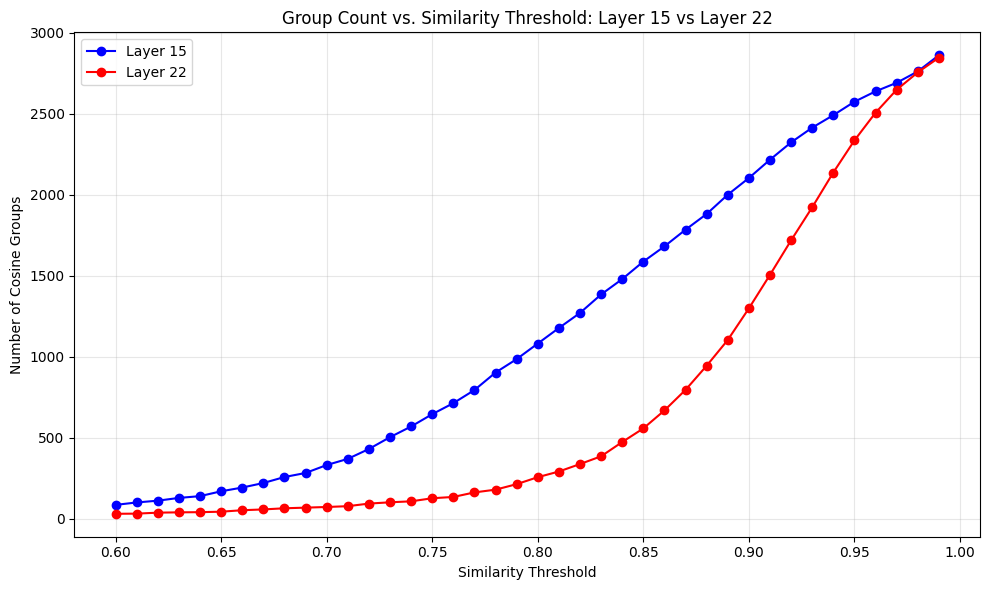

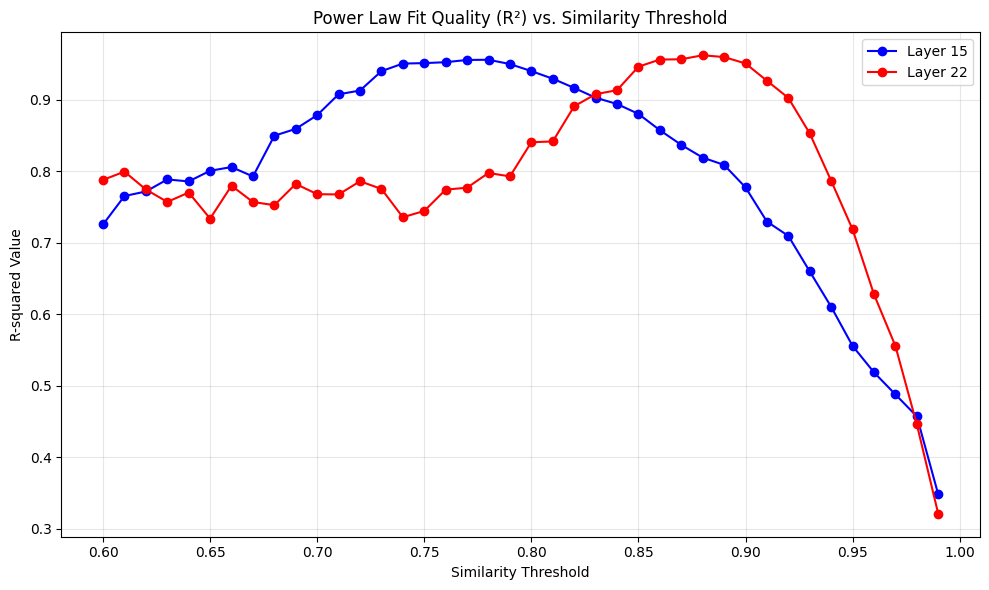

In [ ]:
# Plot showing how group counts change with similarity threshold
layer_comparison_group_count_fig = plt.figure(figsize=(10, 6))
plt.plot(
    cosine_grouping_results_df['Similarity_Threshold'],
    cosine_grouping_results_df['Layer_15_Group_Count'],
    'b-o',
    label='Layer 15'
)
plt.plot(
    cosine_grouping_results_df['Similarity_Threshold'],
    cosine_grouping_results_df['Layer_22_Group_Count'],
    'r-o',
    label='Layer 22'
)
plt.xlabel('Similarity Threshold')
plt.ylabel('Number of Cosine Groups')
plt.title('Group Count vs. Similarity Threshold: Layer 15 vs Layer 22')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('cosine_group_threshold_comparison.png')
plt.show()


# Plot showing how R² values change with similarity threshold
r_squared_comparison_fig = plt.figure(figsize=(10, 6))
plt.plot(
    cosine_grouping_results_df['Similarity_Threshold'],
    cosine_grouping_results_df['Layer_15_R_Squared'],
    'b-o',
    label='Layer 15'
)
plt.plot(
    cosine_grouping_results_df['Similarity_Threshold'],
    cosine_grouping_results_df['Layer_22_R_Squared'],
    'r-o',
    label='Layer 22'
)
plt.xlabel('Similarity Threshold')
plt.ylabel('R-squared Value')
plt.title('Power Law Fit Quality (R²) vs. Similarity Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('cosine_rsquared_threshold_comparison.png')
plt.show()

In [ ]:
# find similarity threshold that produces the highest R² value for each layer
layer_15_best_rsquared_index = cosine_grouping_results_df['Layer_15_R_Squared'].idxmax()
layer_15_best_rsquared_row = cosine_grouping_results_df.iloc[layer_15_best_rsquared_index]

layer_22_best_rsquared_index = cosine_grouping_results_df['Layer_22_R_Squared'].idxmax()
layer_22_best_rsquared_row = cosine_grouping_results_df.iloc[layer_22_best_rsquared_index]

# best thresholds for each layer
cos_group_15_best_thres = layer_15_best_rsquared_row['Similarity_Threshold']
cos_group_22_best_thres = layer_22_best_rsquared_row['Similarity_Threshold']


print("OPTIMAL SIMILARITY THRESHOLDS BASED ON POWER LAW FIT (R²) - COSINE GROUPING")

print("\nLAYER 15 (MIDDLE LAYER) OPTIMAL THRESHOLD:")
print(f"Similarity Threshold: {cos_group_15_best_thres}")
print(f"R² Value: {layer_15_best_rsquared_row['Layer_15_R_Squared']:.4f}")
print(f"Power Law Slope: {layer_15_best_rsquared_row['Layer_15_Power_Law_Slope']:.4f}")
print(f"Number of Groups: {layer_15_best_rsquared_row['Layer_15_Group_Count']}")
print(f"Top Group Sizes: {layer_15_best_rsquared_row['Layer_15_Top_Group_Sizes']}")

print("\nLAYER 22 (FINAL LAYER) OPTIMAL THRESHOLD:")
print(f"Similarity Threshold: {cos_group_22_best_thres}")
print(f"R² Value: {layer_22_best_rsquared_row['Layer_22_R_Squared']:.4f}")
print(f"Power Law Slope: {layer_22_best_rsquared_row['Layer_22_Power_Law_Slope']:.4f}")
print(f"Number of Groups: {layer_22_best_rsquared_row['Layer_22_Group_Count']}")
print(f"Top Group Sizes: {layer_22_best_rsquared_row['Layer_22_Top_Group_Sizes']}")

OPTIMAL SIMILARITY THRESHOLDS BASED ON POWER LAW FIT (R²) - COSINE GROUPING

LAYER 15 (MIDDLE LAYER) OPTIMAL THRESHOLD:
Similarity Threshold: 0.78
R² Value: 0.9558
Power Law Slope: -1.1818
Number of Groups: 902
Top Group Sizes: 244, 205, 192, 137, 124

LAYER 22 (FINAL LAYER) OPTIMAL THRESHOLD:
Similarity Threshold: 0.88
R² Value: 0.9621
Power Law Slope: -1.1110
Number of Groups: 944
Top Group Sizes: 206, 203, 134, 115, 100


# Cosine Similarity Grouping using Layer 15 Best Threshold

In [ ]:
layer_15_cosine_grouping = grouping(
  layer_15_cosine_similarity_matrix,
  n_samples_layer_15,
  cos_group_15_best_thres
)

vector_best_mid_thres_cosine_grouping_middle = count_sentences_per_cluster_grouping(
    layer_15_cosine_grouping)

print(f"\nUpper middle layer (Layer {selected_layers[0]}) using layer 15's best Threshold ({cos_group_15_best_thres:.2f}):")
print(f"Number of groups: {len(layer_15_cosine_grouping)}")
print(f"Vector for group counts(first 10): {vector_best_mid_thres_cosine_grouping_middle[:10]}")

layer_22_cosine_grouping = grouping(
  layer_22_cosine_similarity_matrix,
  n_samples_layer_22,
  cos_group_15_best_thres
)

vector_best_mid_thres_cosine_grouping_final = count_sentences_per_cluster_grouping(
    layer_22_cosine_grouping
)

print(f"\nFinal layer (Layer {selected_layers[1]}) using layer 15's best Threshold ({cos_group_15_best_thres:.2f}):")
print(f"Number of groups: {len(layer_22_cosine_grouping)}")
print(f"Vector for group counts (first 10): {vector_best_mid_thres_cosine_grouping_final[:10]}")



Upper middle layer (Layer 15) using layer 15's best Threshold (0.78):
Number of groups: 902
Vector for group counts(first 10): [244 205 192 137 124 120 110 106  99  93]

Final layer (Layer 22) using layer 15's best Threshold (0.78):
Number of groups: 179
Vector for group counts (first 10): [667 584 519 452 316 271 269 251 249 244]


# Cosine Similarity Grouping using Layer 22 Best Threshold

In [ ]:
layer_15_cosine_grouping = grouping(
  layer_15_cosine_similarity_matrix,
  n_samples_layer_15,
  cos_group_22_best_thres
)

vector_best_final_thres_cosine_grouping_middle = count_sentences_per_cluster_grouping(
    layer_15_cosine_grouping)

print(f"\nUpper middle layer (Layer {selected_layers[0]}) using layer 22's best Threshold ({cos_group_22_best_thres:.2f}):")
print(f"Number of groups: {len(layer_15_cosine_grouping)}")
print(f"Vector for group counts(first 10): {vector_best_final_thres_cosine_grouping_middle[:10]}")

layer_22_cosine_grouping = grouping(
  layer_22_cosine_similarity_matrix,
  n_samples_layer_22,
  cos_group_22_best_thres
)

vector_best_final_thres_cosine_grouping_final = count_sentences_per_cluster_grouping(
    layer_22_cosine_grouping
)

print(f"\nFinal layer (Layer {selected_layers[1]}) using layer 22's best Threshold ({cos_group_22_best_thres:.2f}):")
print(f"Number of groups: {len(layer_22_cosine_grouping)}")
print(f"Vector for group counts (first 10): {vector_best_final_thres_cosine_grouping_final[:10]}")



Upper middle layer (Layer 15) using layer 22's best Threshold (0.88):
Number of groups: 1881
Vector for group counts(first 10): [80 73 69 62 57 54 43 34 30 28]

Final layer (Layer 22) using layer 22's best Threshold (0.88):
Number of groups: 944
Vector for group counts (first 10): [206 203 134 115 100  97  93  90  90  80]


# HDBSCAN
- min_cluster_size = 2


In [ ]:
import random
from functools import partial
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

def hdbscan_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_samples = None,
                      random_state = None):

    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors,
                                n_components = n_components,
                                metric = 'cosine',
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = 2,
                               min_samples = min_samples,
                               metric='euclidean',
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.0 MB/s eta 0:00:00


###HDBSCAN UMAP hyperparameter tuning using Optuna

In [ ]:
# tune UMAP hyper-parameters using Optuna
# Optuna runs one trial per grid point
import optuna
import umap
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score
from functools import partial


MIN_CLUSTER_SIZE = 2
MIN_SAMPLES      = None

def objective(trial, data):
    n_components = trial.suggest_int("n_components", 10, 40, step=5)
    n_neighbors  = trial.suggest_int("n_neighbors",  10, 40, step=5)

    reducer   = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        random_state=42,
        metric="euclidean",
        low_memory=True,
    )
    embedding = reducer.fit_transform(data)

    labels = HDBSCAN(
        min_cluster_size=MIN_CLUSTER_SIZE,

        **({} if MIN_SAMPLES is None else {"min_samples": MIN_SAMPLES})
    ).fit_predict(embedding)

    return silhouette_score(embedding, labels) if len(set(labels)) > 1 else -1

search_space = {
    "n_components": list(range(10, 41, 5)),
    "n_neighbors" : list(range(10, 41, 5)),
}

In [ ]:
def tune_umap(data):
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.GridSampler(search_space),
    )
    study.optimize(partial(objective, data=data))
    return study

In [ ]:
layer15_study = tune_umap(norm_layer_15)
print("Layer 15 best score :", layer15_study.best_value)
print("Layer 15 best params:", layer15_study.best_params)

[I 2025-05-12 17:13:35,465] A new study created in memory with name: no-name-12da4f5b-f414-4081-9289-60cfae3b23b1
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-12 17:14:06,306] Trial 0 finished with value: 0.13878488540649414 and parameters: {'n_components': 30, 'n_neighbors': 15}. B

Layer 15 best score : 0.2028784155845642
Layer 15 best params: {'n_components': 30, 'n_neighbors': 10}


In [ ]:
layer22_study = tune_umap(norm_layer_22)
print("Layer 22 best score :", layer22_study.best_value)
print("Layer 22 best params:", layer22_study.best_params)

[I 2025-05-12 17:33:42,966] A new study created in memory with name: no-name-a3e83bf1-8cc8-4857-ba21-8f54772807d4
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-12 17:34:06,993] Trial 0 finished with value: 0.15855544805526733 and parameters: {'n_components': 30, 'n_neighbors': 15}. B

Layer 22 best score : 0.2559511363506317
Layer 22 best params: {'n_components': 10, 'n_neighbors': 10}


### Run HDBSCAN

In [ ]:
# count sentences per cluster
def count_sentences_per_hdbscan_cluster(cluster_labels):
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    counts = np.zeros(num_clusters, dtype=int)

    for label in cluster_labels:
        # skip noise points
        if label != -1:
            counts[label] += 1

    return counts

### HDBSCAN using best params for layer 15

In [ ]:
import numpy as np

# Layer 15
clusters15_best15 = hdbscan_clusters(
    norm_layer_15,
    n_neighbors=10,  #20
    n_components=30, #30
    random_state=42
)
labels_hdbscan15_best15 = clusters15_best15.labels_
num_clusters15_best15 = len(set(labels_hdbscan15_best15)) - (1 if -1 in labels_hdbscan15_best15 else 0)
print(f"Layer 15 (using best params for layer 15): {num_clusters15_best15} clusters")

# Layer 22
clusters22_best15 = hdbscan_clusters(
    norm_layer_22,
    n_neighbors=10,
    n_components=30,
    random_state=42
)
labels_hdbscan22_best15 = clusters22_best15.labels_
num_clusters22_best15 = len(set(labels_hdbscan22_best15)) - (1 if -1 in labels_hdbscan22_best15 else 0)
print(f"Layer 22 (using best params for layer 15): {num_clusters22_best15} clusters")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Layer 15 (using best params for layer 15): 371 clusters


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Layer 22 (using best params for layer 15): 368 clusters


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# count sentences per cluster for each layer
sentence_counts_hdbscan_layer15_best15 = count_sentences_per_hdbscan_cluster(labels_hdbscan15_best15)
sentence_counts_hdbscan_layer22_best15 = count_sentences_per_hdbscan_cluster(labels_hdbscan22_best15)

# vectorize and sort the counts in descending order
vector_sent_hdbscan_layer15_best15 = np.array(sorted(sentence_counts_hdbscan_layer15_best15, reverse=True))
vector_sent_hdbscan_layer22_best15 = np.array(sorted(sentence_counts_hdbscan_layer22_best15, reverse=True))


# Print the distribution of sentences across clusters
print("\nDistribution of sentences across clusters: ")

print(f"\nLayer 15 ({num_clusters15_best15} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer15_best15)}")
print(f"Noise points: {np.sum(labels_hdbscan15_best15 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer15_best15[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer15_best15}")

print(f"\nLayer 22 ({num_clusters22_best15} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer22_best15)}")
print(f"Noise points: {np.sum(labels_hdbscan22_best15 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer22_best15[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer22_best15}")



Distribution of sentences across clusters: 

Layer 15 (371 clusters):
Total sentences in clusters: 2335
Noise points: 665
Top 5 clusters: [62 34 29 27 26]
Sentence distribution: [62 34 29 27 26 24 21 21 20 20 20 19 19 18 18 17 17 16 16 15 15 15 15 14
 14 14 14 14 13 13 13 13 12 12 12 12 11 11 11 11 11 11 11 11 10 10 10 10
 10 10 10 10 10 10 10  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3

### HDBSCAN using best params for layer 22

In [ ]:
# Layer 15
clusters15_best22 = hdbscan_clusters(
    norm_layer_15,
    n_neighbors=10,
    n_components=10,
    random_state=42
)
labels_hdbscan15_best22 = clusters15_best22.labels_
num_clusters15_best22 = len(set(labels_hdbscan15_best22)) - (1 if -1 in labels_hdbscan15_best22 else 0)
print(f"Layer 15 (using best params for layer 22): {num_clusters15_best22} clusters")

# Layer 22
clusters22_best22 = hdbscan_clusters(
    norm_layer_22,
    n_neighbors=10,
    n_components=10,
    random_state=42
)
labels_hdbscan22_best22 = clusters22_best22.labels_
num_clusters22_best22 = len(set(labels_hdbscan22_best22)) - (1 if -1 in labels_hdbscan22_best22 else 0)
print(f"Layer 22 (using best params for layer 22): {num_clusters22_best22} clusters")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:

Layer 15 (using best params for layer 22): 380 clusters
Layer 22 (using best params for layer 22): 358 clusters


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# count sentences per cluster for each layer
sentence_counts_hdbscan_layer15_best22 = count_sentences_per_hdbscan_cluster(labels_hdbscan15_best22)
sentence_counts_hdbscan_layer22_best22 = count_sentences_per_hdbscan_cluster(labels_hdbscan22_best22)

# vectorize and sort the counts in descending order
vector_sent_hdbscan_layer15_best22 = np.array(sorted(sentence_counts_hdbscan_layer15_best22, reverse=True))
vector_sent_hdbscan_layer22_best22 = np.array(sorted(sentence_counts_hdbscan_layer22_best22, reverse=True))

# Print the distribution of sentences across clusters
print("\nDistribution of sentences across clusters: ")

print(f"\nLayer 15 ({num_clusters15_best22} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer15_best22)}")
print(f"Noise points: {np.sum(labels_hdbscan15_best22 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer15_best22[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer15_best22}")

print(f"\nLayer 22 ({num_clusters22_best22} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer22_best22)}")
print(f"Noise points: {np.sum(labels_hdbscan22_best22 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer22_best22[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer22_best22}")



Distribution of sentences across clusters: 

Layer 15 (380 clusters):
Total sentences in clusters: 2293
Noise points: 707
Top 5 clusters: [100  28  23  22  19]
Sentence distribution: [100  28  23  22  19  18  18  18  17  17  16  16  15  15  15  14  14  14
  14  14  13  13  13  13  13  13  12  12  12  12  12  12  12  11  11  11
  11  11  11  11  10  10  10  10  10  10  10  10  10  10  10   9   9   9
   9   9   9   9   9   9   9   9   9   9   9   9   9   9   9   9   8   8
   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   7
   7   7   7   7   7   7   7   7   7   7   7   7   7   7   7   7   7   7
   7   7   7   7   7   7   6   6   6   6   6   6   6   6   6   6   6   6
   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6
   6   6   6   6   6   6   6   6   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   4   4   4 

# Plot

Saved plot: new_clustering_wiki_plots/Layer 15 - DBSCAN Clustering_wiki.png


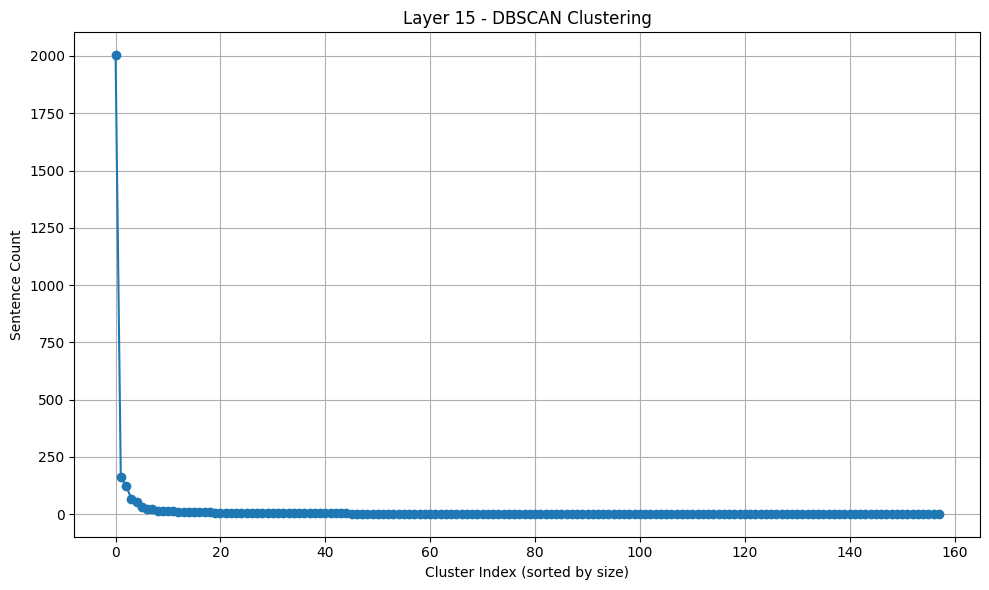

Saved plot: new_clustering_wiki_plots/Last Layer - DBSCAN Clustering_wiki.png


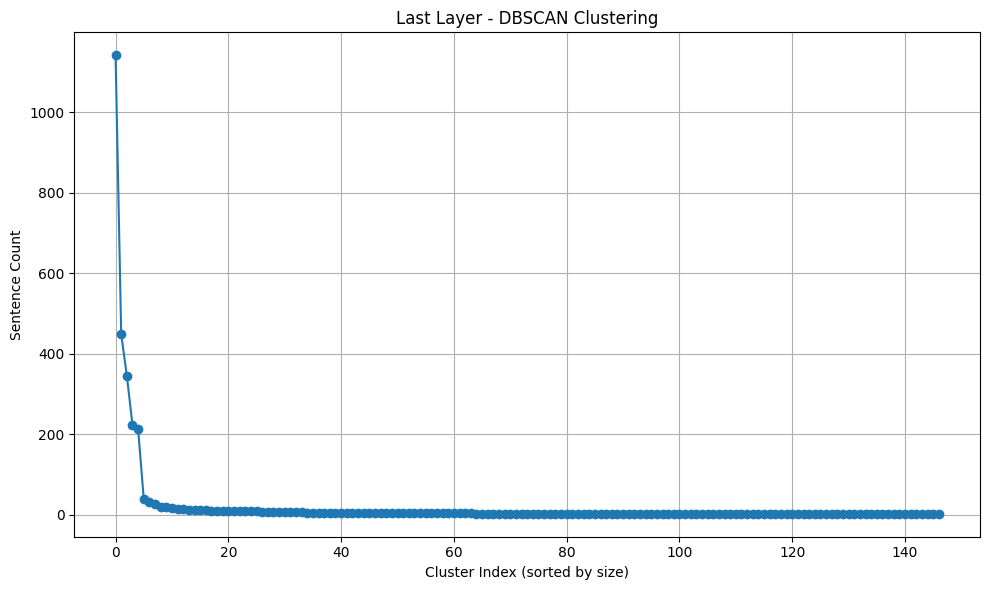

Saved plot: new_clustering_wiki_plots/Layer 15 - K-means Clustering_wiki.png


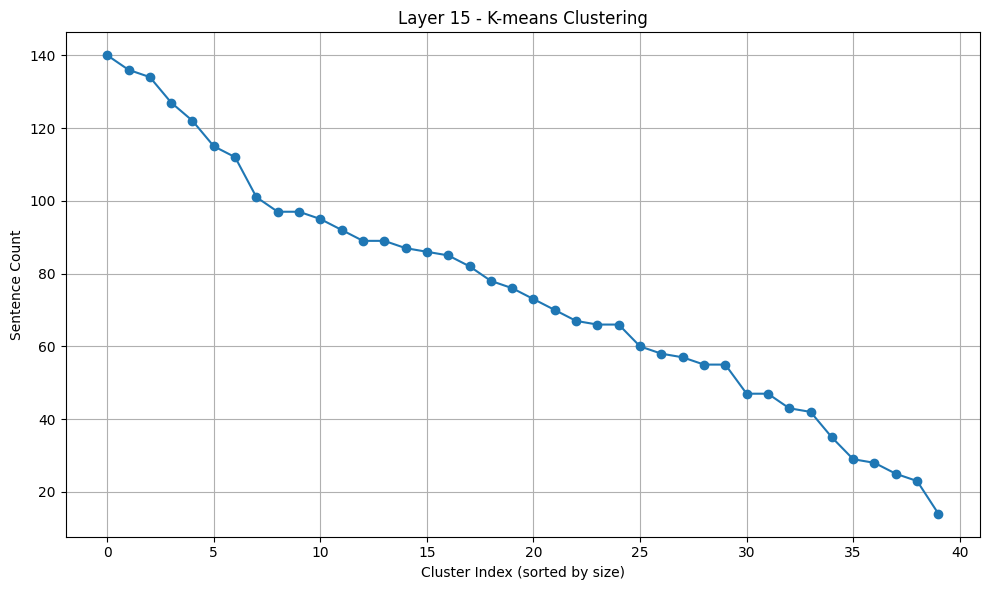

Saved plot: new_clustering_wiki_plots/Last Layer - K-means Clustering_wiki.png


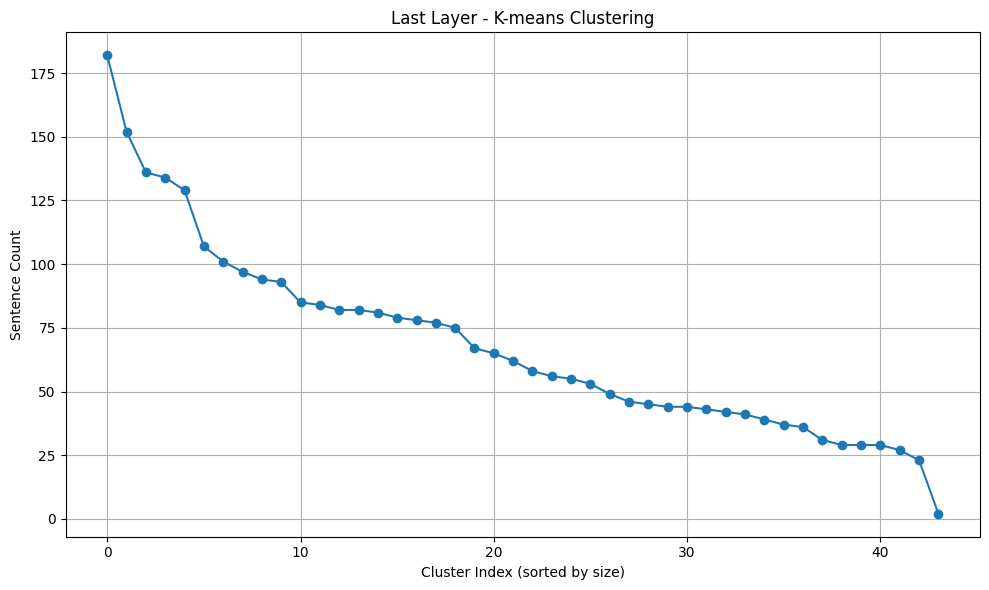

Saved plot: new_clustering_wiki_plots/Layer 15 - Cosine Similarity Grouping (Best Threshold for Layer 15)_wiki.png


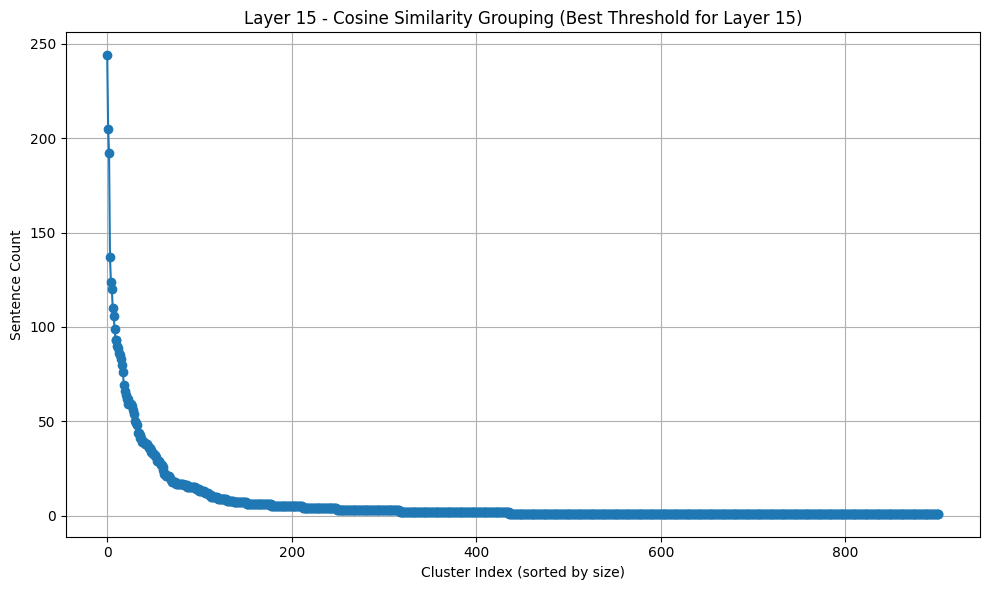

Saved plot: new_clustering_wiki_plots/Final Layer - Cosine Similarity Grouping (Best Threshold for Layer 15)_wiki.png


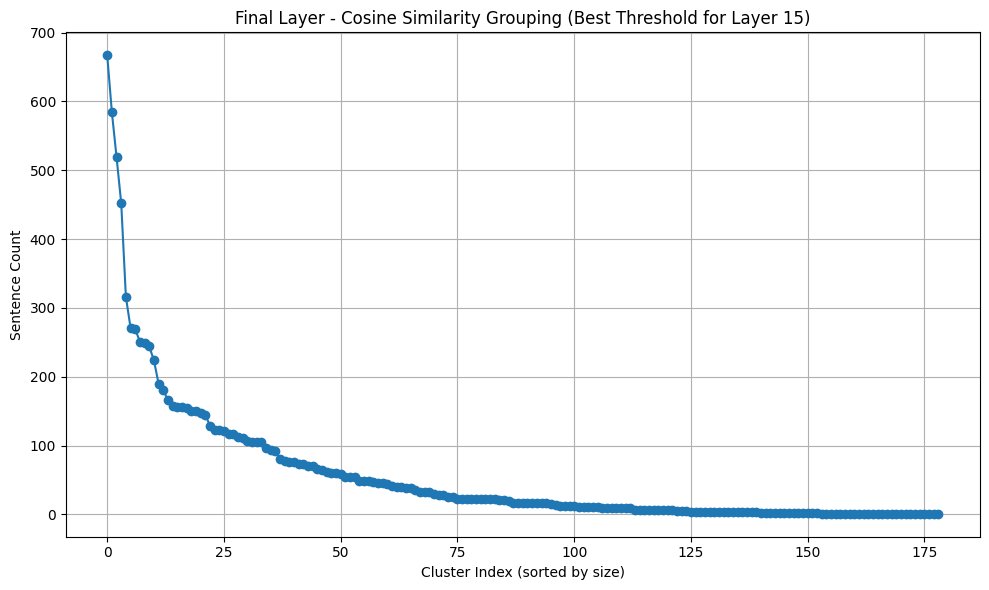

Saved plot: new_clustering_wiki_plots/Layer 15 - Cosine Similarity Grouping (Best Threshold for Final Layer)_wiki.png


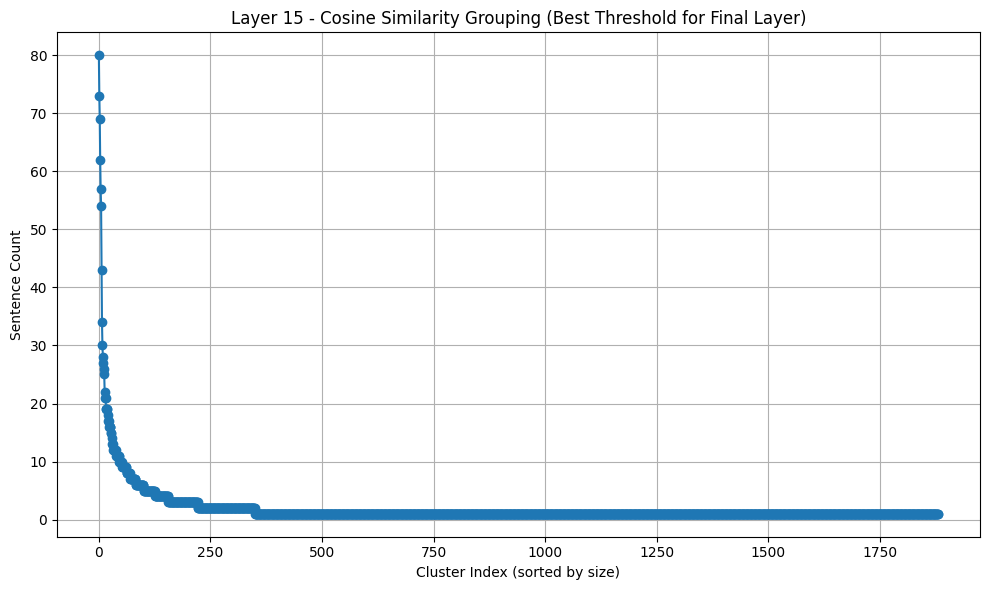

Saved plot: new_clustering_wiki_plots/Final Layer - Cosine Similarity Grouping (Best Threshold for Final Layer)_wiki.png


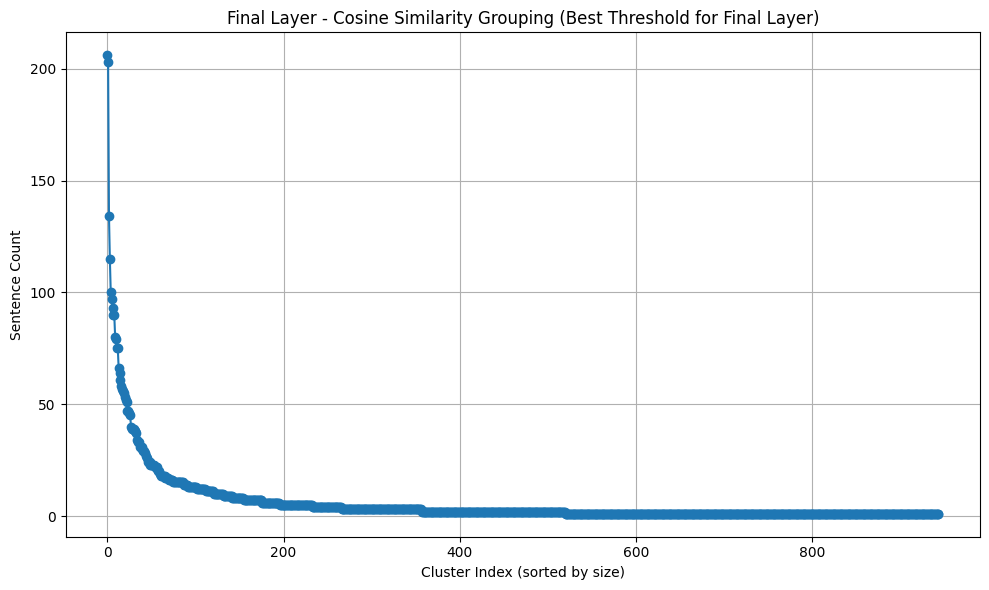

Saved plot: new_clustering_wiki_plots/Layer 15 - HDBSCAN Clustering (Layer15 Best Params)_wiki.png


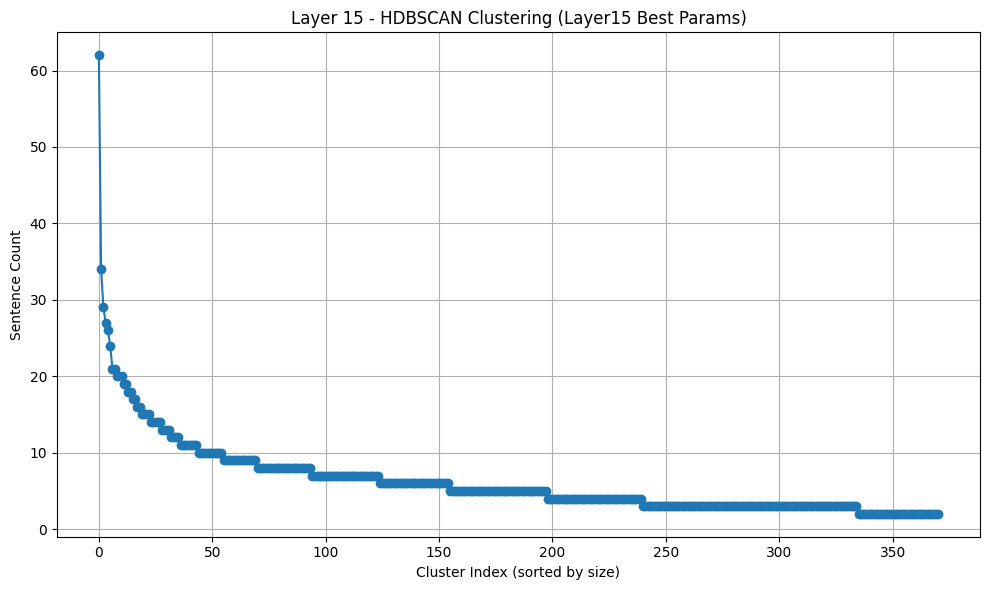

Saved plot: new_clustering_wiki_plots/Final Layer - HDBSCAN Clustering (Layer15 Best Params)_wiki.png


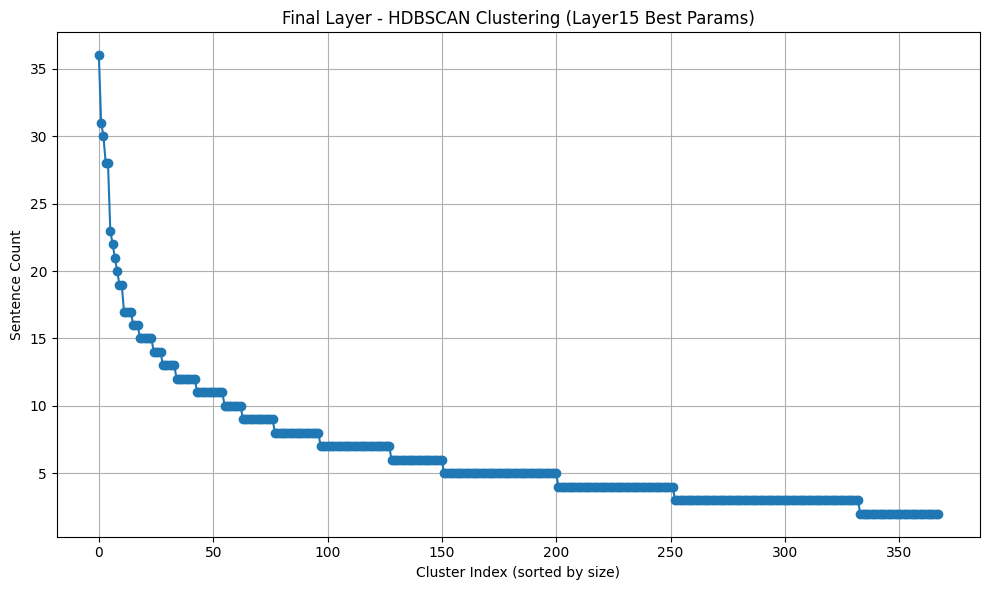

Saved plot: new_clustering_wiki_plots/Layer 15 - HDBSCAN Clustering (Layer22 Best Params)_wiki.png


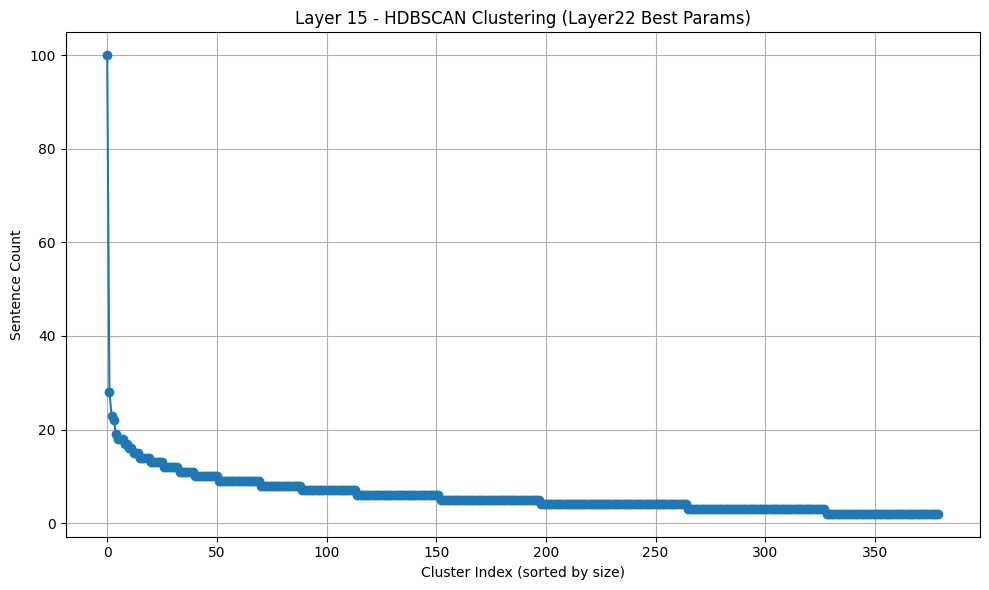

Saved plot: new_clustering_wiki_plots/Final Layer - HDBSCAN Clustering (Layer22 Best Params)_wiki.png


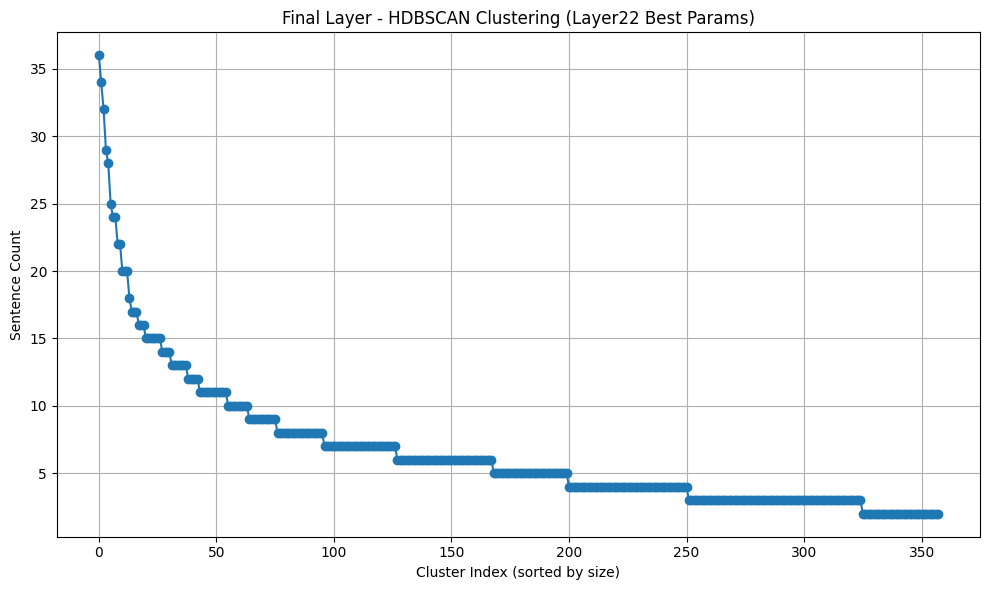

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("new_clustering_wiki_plots", exist_ok=True)

vectors = [
    (vector_sent_dbscan_middle, "Layer 15 - DBSCAN Clustering", "middle", "dbscan"),
    (vector_sent_dbscan_last, "Last Layer - DBSCAN Clustering", "last", "dbscan"),

    (vector_sent_kmeans_mid, "Layer 15 - K-means Clustering", "middle", "kmeans"),
    (vector_sent_kmeans_last, "Last Layer - K-means Clustering", "last", "kmeans"),

    (vector_best_mid_thres_cosine_grouping_middle, "Layer 15 - Cosine Similarity Grouping (Best Threshold for Layer 15)", "middle", "cosine"),
    (vector_best_mid_thres_cosine_grouping_final, "Final Layer - Cosine Similarity Grouping (Best Threshold for Layer 15)", "last", "cosine"),
    (vector_best_final_thres_cosine_grouping_middle, "Layer 15 - Cosine Similarity Grouping (Best Threshold for Final Layer)", "middle", "cosine"),
    (vector_best_final_thres_cosine_grouping_final, "Final Layer - Cosine Similarity Grouping (Best Threshold for Final Layer)", "last", "cosine"),

    (vector_sent_hdbscan_layer15_best15, "Layer 15 - HDBSCAN Clustering (Layer15 Best Params)", "middle", "hdbscan"),
    (vector_sent_hdbscan_layer22_best15, "Final Layer - HDBSCAN Clustering (Layer15 Best Params)", "last", "hdbscan"),
    (vector_sent_hdbscan_layer15_best22, "Layer 15 - HDBSCAN Clustering (Layer22 Best Params)", "middle", "hdbscan"),
    (vector_sent_hdbscan_layer22_best22, "Final Layer - HDBSCAN Clustering (Layer22 Best Params)", "last", "hdbscan"),
]

for vector, title, layer_name, method_name in vectors:
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(vector)), sorted(vector, reverse=True), marker='o')
    plt.title(title)
    plt.xlabel('Cluster Index (sorted by size)')
    plt.ylabel('Sentence Count')
    plt.grid(True)
    plt.tight_layout()

    filename = f"new_clustering_wiki_plots/{title}_wiki.png"
    plt.savefig(filename)
    print(f"Saved plot: {filename}")
    plt.show()

layer_titles = ["2/3th Layer", "Last Layer"]
layer_names = ["middle", "last"]
clustering_methods = ["dbscan", "kmeans", "cosine"]



In [ ]:
import shutil
shutil.make_archive('/content/new_clustering_wiki_plots', 'zip', 'new_clustering_wiki_plots')
from google.colab import files
files.download('new_clustering_wiki_plots.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - DBSCAN Clustering_wiki.png


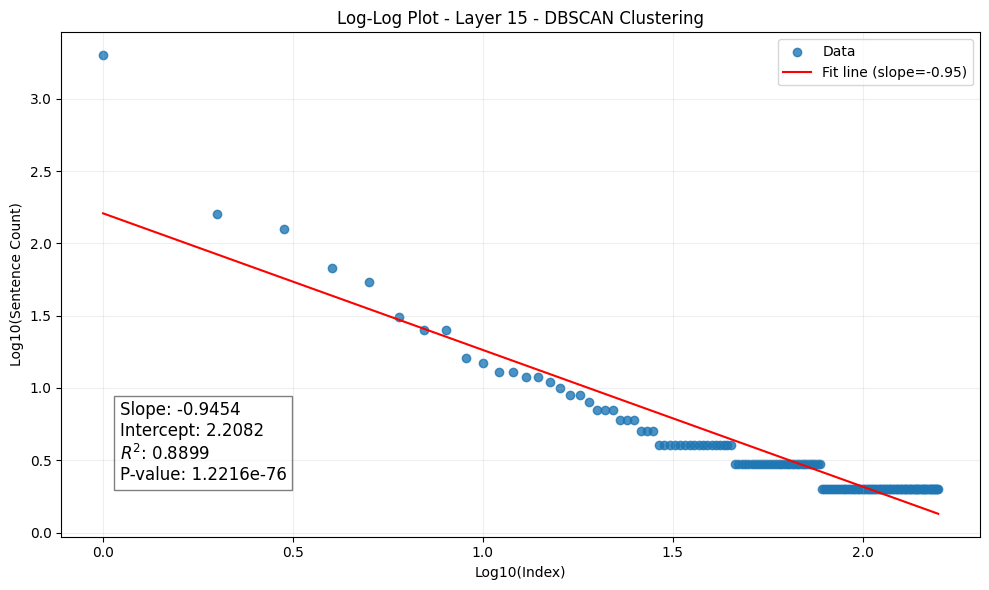


Regression Results for Layer 15 - DBSCAN Clustering:
   - Slope: -0.9454
   - Intercept: 2.2082
   - R-squared: 0.8899
   - P-value: 1.2216e-76
Saved plot: new_loglog_wiki_plots/loglog_Last Layer - DBSCAN Clustering_wiki.png


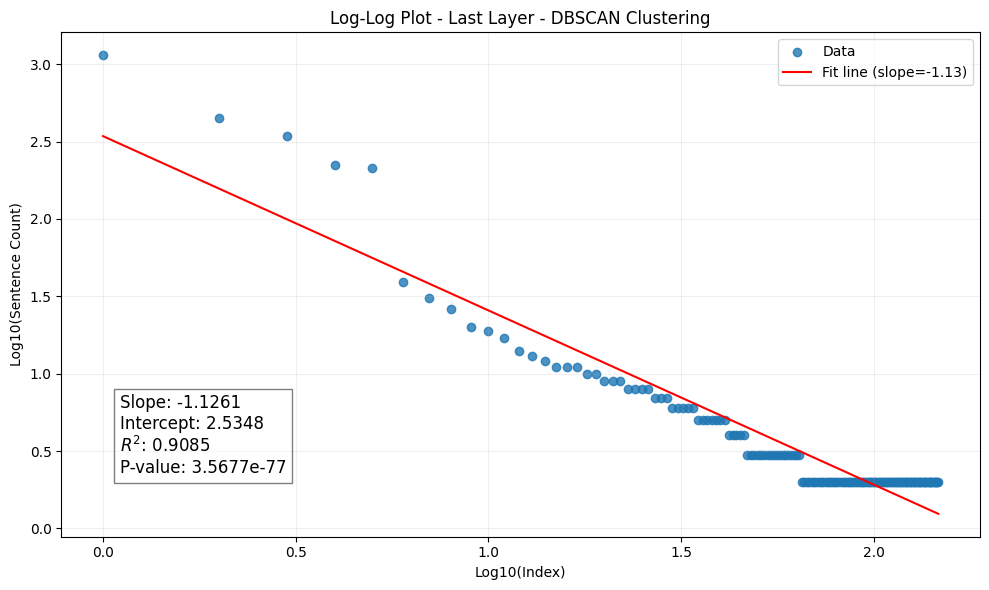


Regression Results for Last Layer - DBSCAN Clustering:
   - Slope: -1.1261
   - Intercept: 2.5348
   - R-squared: 0.9085
   - P-value: 3.5677e-77
Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - K-means Clustering_wiki.png


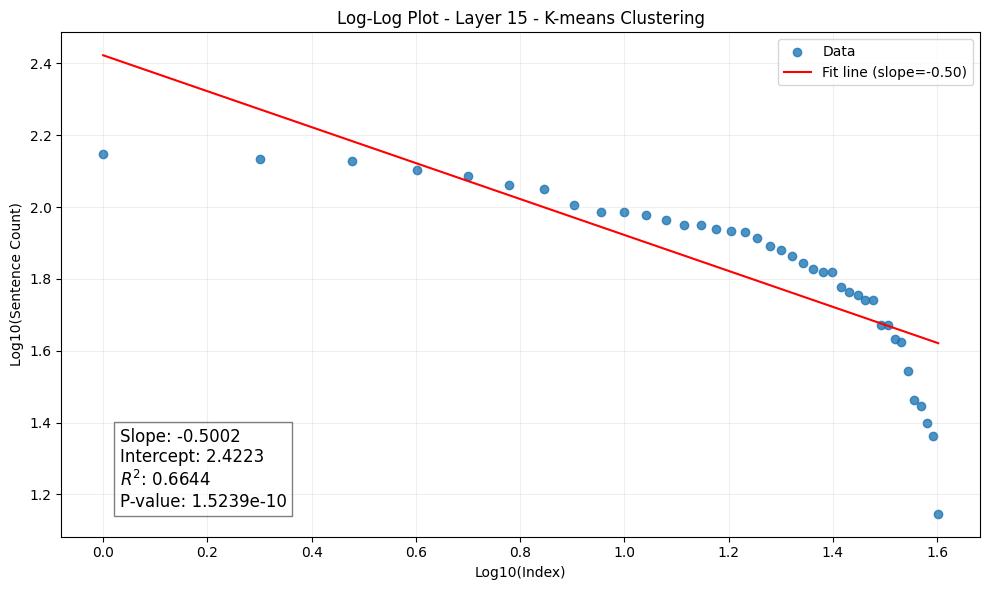


Regression Results for Layer 15 - K-means Clustering:
   - Slope: -0.5002
   - Intercept: 2.4223
   - R-squared: 0.6644
   - P-value: 1.5239e-10
Saved plot: new_loglog_wiki_plots/loglog_Last Layer - K-means Clustering_wiki.png


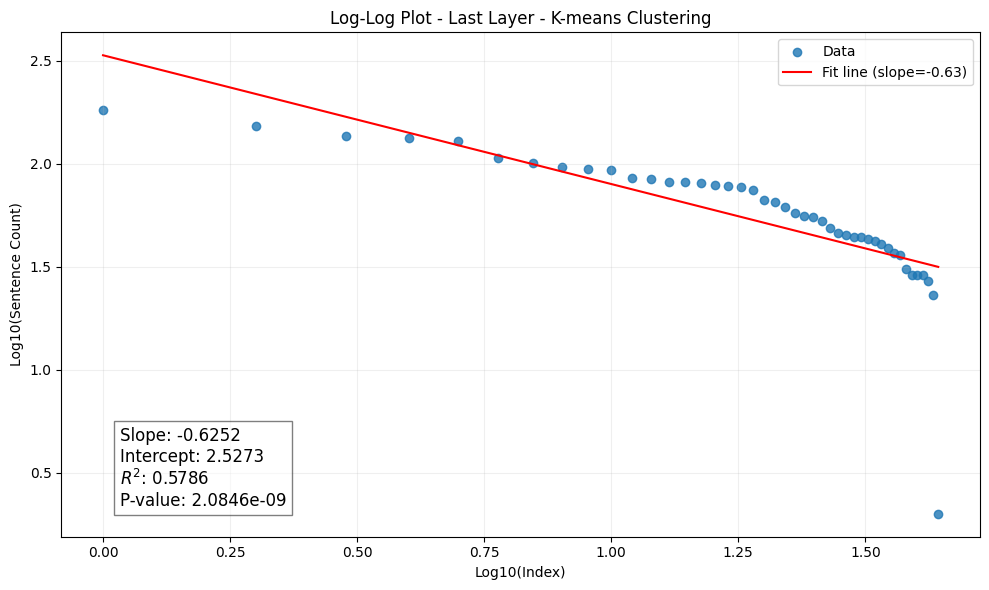


Regression Results for Last Layer - K-means Clustering:
   - Slope: -0.6252
   - Intercept: 2.5273
   - R-squared: 0.5786
   - P-value: 2.0846e-09
Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - Cosine Similarity Grouping (Best Threshold for Layer 15)_wiki.png


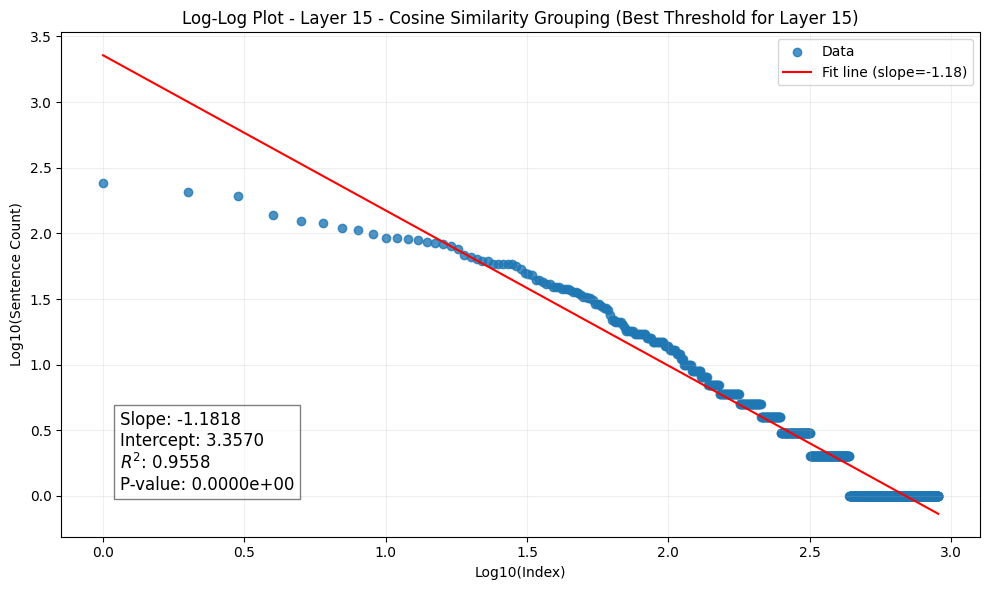


Regression Results for Layer 15 - Cosine Similarity Grouping (Best Threshold for Layer 15):
   - Slope: -1.1818
   - Intercept: 3.3570
   - R-squared: 0.9558
   - P-value: 0.0000e+00
Saved plot: new_loglog_wiki_plots/loglog_Final Layer - Cosine Similarity Grouping (Best Threshold for Layer 15)_wiki.png


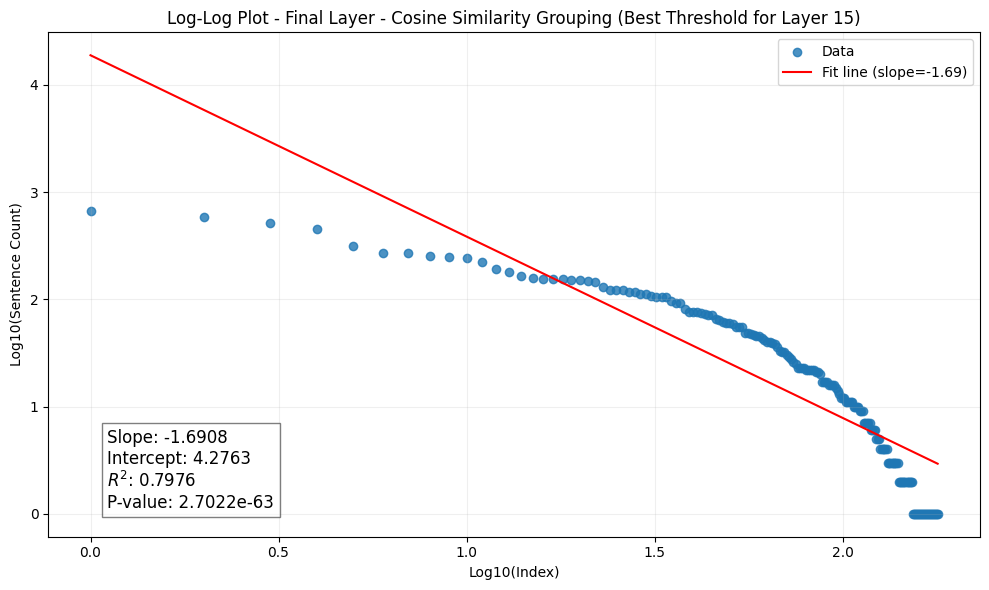


Regression Results for Final Layer - Cosine Similarity Grouping (Best Threshold for Layer 15):
   - Slope: -1.6908
   - Intercept: 4.2763
   - R-squared: 0.7976
   - P-value: 2.7022e-63
Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - Cosine Similarity Grouping (Best Threshold for Final Layer)_wiki.png


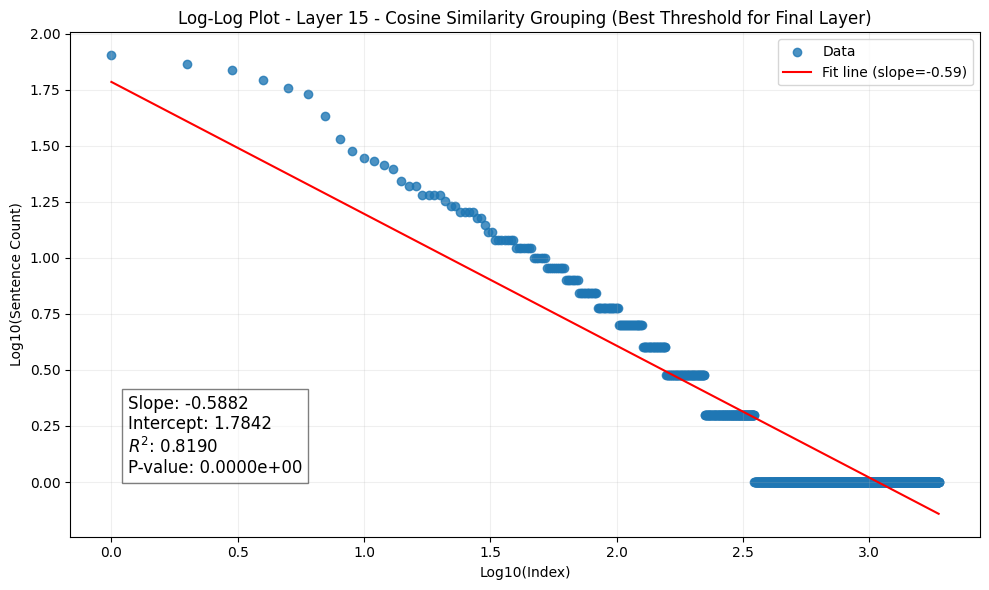


Regression Results for Layer 15 - Cosine Similarity Grouping (Best Threshold for Final Layer):
   - Slope: -0.5882
   - Intercept: 1.7842
   - R-squared: 0.8190
   - P-value: 0.0000e+00
Saved plot: new_loglog_wiki_plots/loglog_Final Layer - Cosine Similarity Grouping (Best Threshold for Final Layer)_wiki.png


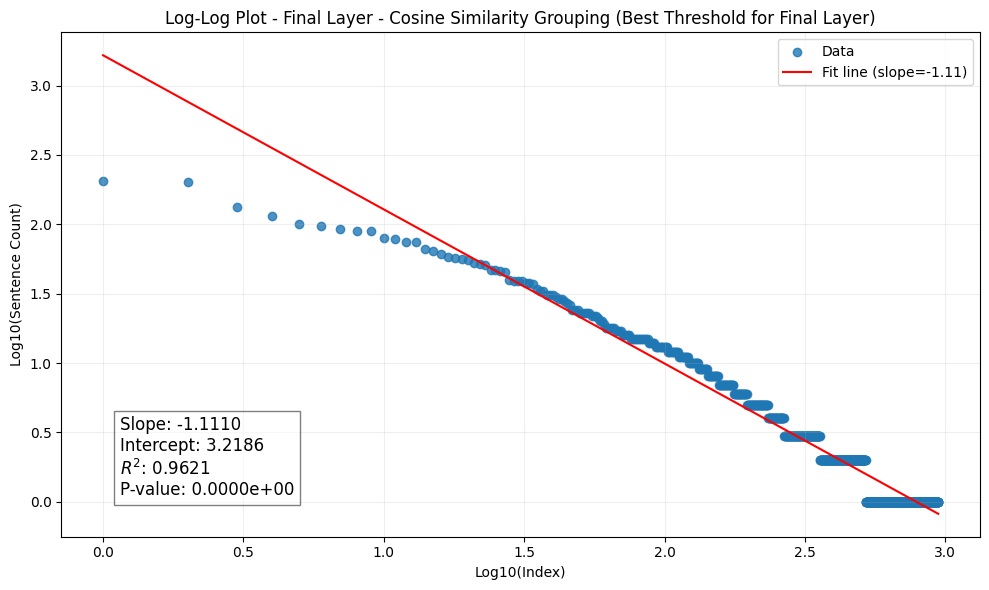


Regression Results for Final Layer - Cosine Similarity Grouping (Best Threshold for Final Layer):
   - Slope: -1.1110
   - Intercept: 3.2186
   - R-squared: 0.9621
   - P-value: 0.0000e+00
Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - HDBSCAN Clustering (Layer15 Best Params)_wiki.png


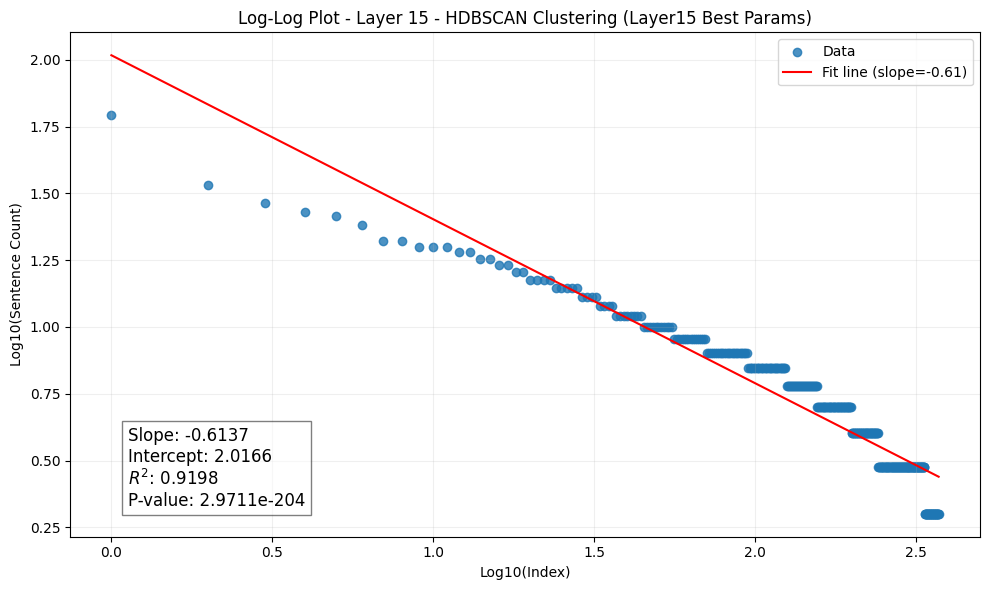


Regression Results for Layer 15 - HDBSCAN Clustering (Layer15 Best Params):
   - Slope: -0.6137
   - Intercept: 2.0166
   - R-squared: 0.9198
   - P-value: 2.9711e-204
Saved plot: new_loglog_wiki_plots/loglog_Final Layer - HDBSCAN Clustering (Layer15 Best Params)_wiki.png


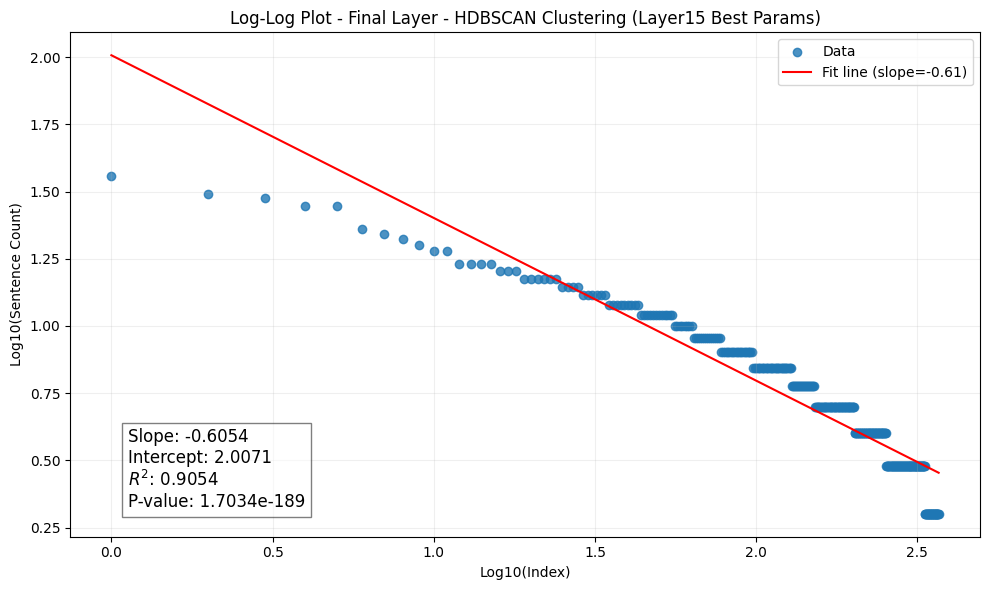


Regression Results for Final Layer - HDBSCAN Clustering (Layer15 Best Params):
   - Slope: -0.6054
   - Intercept: 2.0071
   - R-squared: 0.9054
   - P-value: 1.7034e-189
Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - HDBSCAN Clustering (Layer22 Best Params)_wiki.png


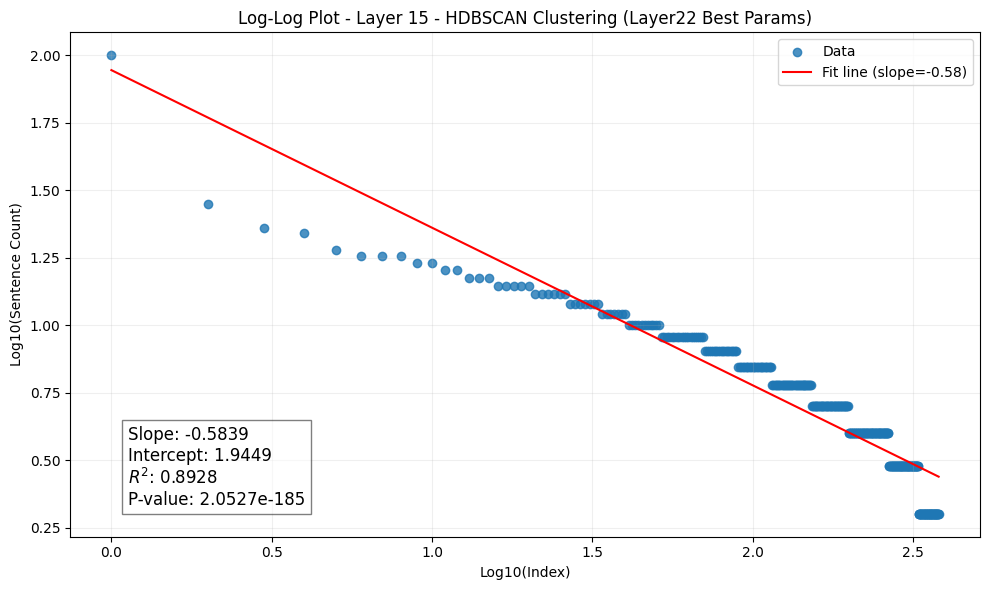


Regression Results for Layer 15 - HDBSCAN Clustering (Layer22 Best Params):
   - Slope: -0.5839
   - Intercept: 1.9449
   - R-squared: 0.8928
   - P-value: 2.0527e-185
Saved plot: new_loglog_wiki_plots/loglog_Final Layer - HDBSCAN Clustering (Layer22 Best Params)_wiki.png


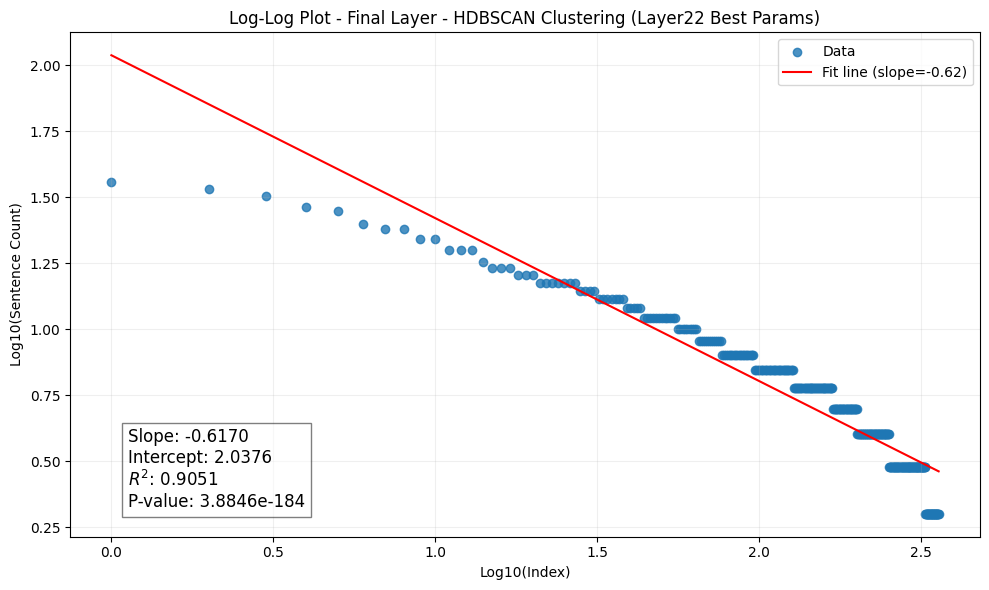


Regression Results for Final Layer - HDBSCAN Clustering (Layer22 Best Params):
   - Slope: -0.6170
   - Intercept: 2.0376
   - R-squared: 0.9051
   - P-value: 3.8846e-184
Saved slope comparison: loglog_wiki_plots/loglog_slope_comparison_wiki.png


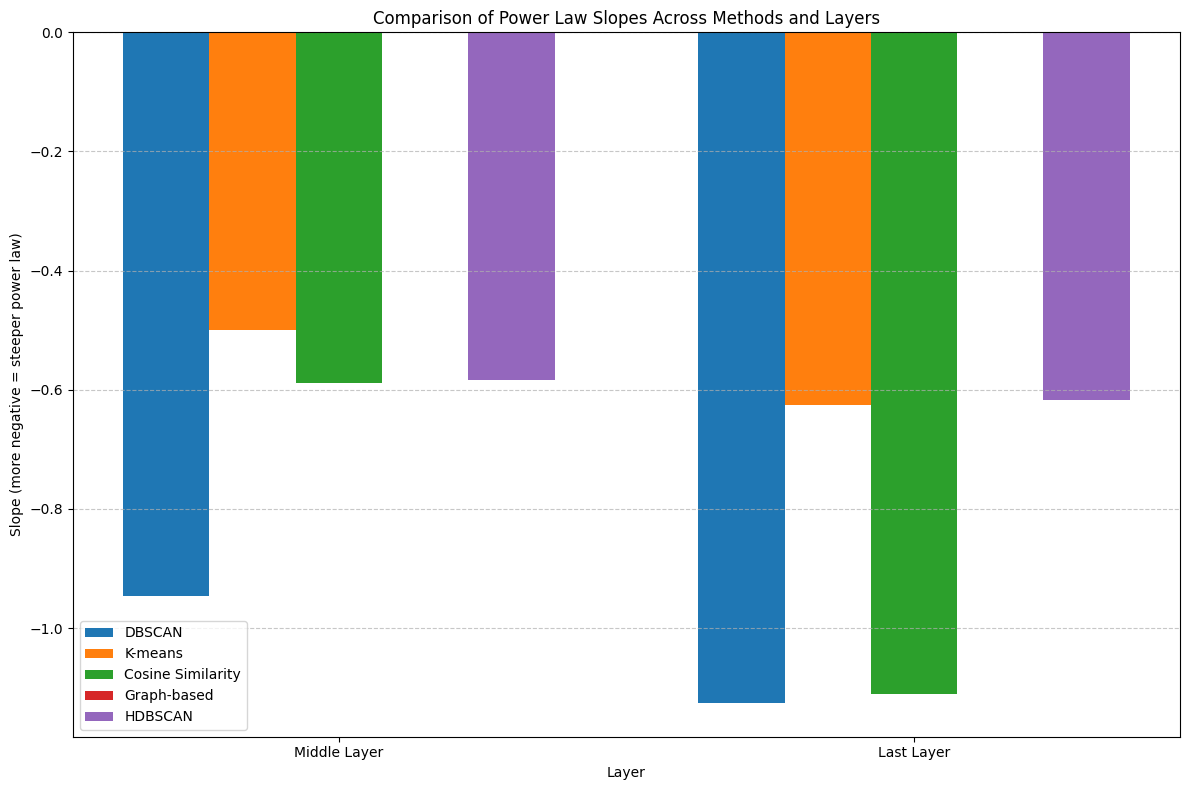

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

os.makedirs("new_loglog_wiki_plots", exist_ok=True)

def linear_regression(counts):
    valid_counts = counts[counts > 0]
    if len(valid_counts) <= 1:
        return None, None, 0, 0, 0, 1, None
    x = np.log10(np.arange(1, len(valid_counts)+1))
    y = np.log10(valid_counts)
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    y_pred = slope * x + intercept
    return x, y, slope, intercept, r_val, p_val, y_pred

for vector, title, layer_key, method_key in vectors:
    x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(np.array(vector))
    if x is None:
        print(f"Regression failed for {title} - not enough valid data points")
        continue

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.8, label='Data')
    plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')

    plt.title(f"Log-Log Plot - {title}")
    plt.xlabel('Log10(Index)')
    plt.ylabel('Log10(Sentence Count)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    text_x = min(x) + (max(x) - min(x)) * 0.02
    text_y = min(y) + (max(y) - min(y)) * 0.02
    plt.text(text_x, text_y,
             f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    filename = f"new_loglog_wiki_plots/loglog_{title}_wiki.png"
    plt.savefig(filename)
    print(f"Saved plot: {filename}")
    plt.show()

    method = title.split(" - ")[1]
    layer = title.split(" - ")[0]

    print(f"\nRegression Results for {title}:")
    print(f"   - Slope: {slope:.4f}")
    print(f"   - Intercept: {intercept:.4f}")
    print(f"   - R-squared: {r_val**2:.4f}")
    print(f"   - P-value: {p_val:.4e}")


methods = ["dbscan", "kmeans", "cosine", "graph", "hdbscan"]
layers = ["middle", "last"]
method_labels = ["DBSCAN", "K-means", "Cosine Similarity", "Graph-based", "HDBSCAN"]
layer_labels = ["Middle Layer", "Last Layer"]

slope_matrix = np.zeros((len(methods), len(layers)))
r2_matrix = np.zeros((len(methods), len(layers)))

for vector, title, layer_key, method_key in vectors:
    if method_key in methods and layer_key in layers:
        method_idx = methods.index(method_key)
        layer_idx = layers.index(layer_key)
        x, y, slope, _, r_val, _, _ = linear_regression(np.array(vector))
        if x is not None:
            slope_matrix[method_idx, layer_idx] = slope
            r2_matrix[method_idx, layer_idx] = r_val**2

plt.figure(figsize=(12, 8))
x = np.arange(len(layers))
width = 0.15
for i, method in enumerate(method_labels):
    plt.bar(x + (i - 2) * width, slope_matrix[i], width, label=method)

plt.xlabel('Layer')
plt.ylabel('Slope (more negative = steeper power law)')
plt.title('Comparison of Power Law Slopes Across Methods and Layers')
plt.xticks(x, layer_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("loglog_wiki_plots/loglog_slope_comparison_wiki.png")
print("Saved slope comparison: loglog_wiki_plots/loglog_slope_comparison_wiki.png")
plt.show()


In [ ]:
import shutil
shutil.make_archive('/content/new_loglog_wiki_plots', 'zip', 'new_loglog_wiki_plots')
from google.colab import files
files.download('new_loglog_wiki_plots.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>